In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#loading the dataset
df = pd.read_csv('../data/OnlineNewsPopularity.csv')

In [8]:
df.columns = df.columns.str.strip()

## Outlier Analysis

Outliers are data points that deviate significantly from the majority of observations in a dataset. They represent values that are unusually high or low compared to the rest of the data distribution.
These values will effect our statistical analysis and therefore our models' performances.

Outliers can occur due to:
* Data entry/ measurement errors
* Sampling problems
* Natural variations

We will first start by identifying the existence of the outliers in the dataset :
* **Univariate outliers**: We should examine each numerical feature individually first

* **Multivariate outliers**: We can look for unusual combinations of values across features later

In [19]:
numerical_cols=df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Get categorical columns (object and category types)
    
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [23]:
def get_column_types(df):
    # Get all numerical columns (includes both continuous and binary)
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Get categorical columns (object and category types)
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Get boolean columns
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
    
    # Separate numerical into continuous vs binary
    continuous_cols = []
    binary_cols = []
    
    for col in numerical_cols:
        # Check if column is binary (has exactly 2 unique values)
        if len(df[col].unique()) == 2:
            binary_cols.append(col)
        else:
            continuous_cols.append(col)
    
    return {
        'all_numerical': numerical_cols,
        'continuous': continuous_cols,
        'binary': binary_cols,
        'categorical': categorical_cols,
        'boolean': bool_cols
    }

# Usage example:
column_types = get_column_types(df)

# Access the different types:
continuous_cols = column_types['continuous']  # Your numerical non-binary columns
binary_cols = column_types['binary']
categorical_cols = column_types['categorical']
bool_clos = column_types['boolean']

print("Continuous Columns:")
print(continuous_cols)
print("\nBinary Columns:")
print(binary_cols)
print("\nCategorical Columns:")
print(categorical_cols)
print("\bool Columns:")
print(bool_clos)


Continuous Columns:
['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity', 'shares']

Binary Columns:
['data_channel_is_lifestyle', 'data_channel_is_entertainm

First we start by visulizing the histogram for the continuous valued columns only because the categorical url is not needed and the binary cannot have outliers

In [10]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

In [11]:
# Function to detect outliers using Z-score (for normally distributed data)
def detect_outliers_zscore(data, column, threshold=3):
    z_scores = (data[column] - data[column].mean()) / data[column].std()
    outliers = data[abs(z_scores) > threshold]
    return outliers

In [25]:
def visualize_outliers(data, column):
    plt.figure(figsize=(12, 6))
    
    # Boxplot (less memory intensive)
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')
    
    # Histogram with manual bins
    plt.subplot(1, 2, 2)
    try:
        # if data[column].max() / data[column].median() > 1000:  # Extreme range
        #     n_bins = np.linspace(0, data[column].quantile(0.99), 100)
        # else:
        #     n_bins = 'auto'
        # Calculate reasonable bin count (max 1000 bins)
        #n_bins = min(1000, len(data[column].unique()))
        sns.histplot(data[column], bins='auto', kde=False)
    except MemoryError:
        # Fallback to value counts for very large data
        value_counts = data[column].value_counts().sort_index()
        plt.bar(value_counts.index, value_counts.values)
    
    plt.title(f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

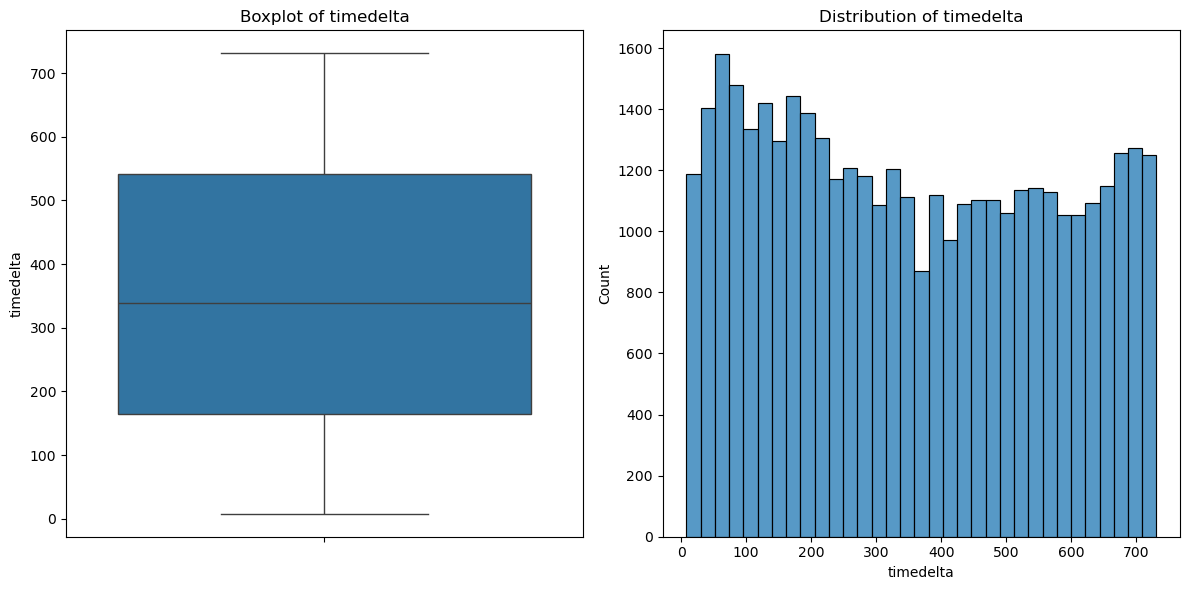

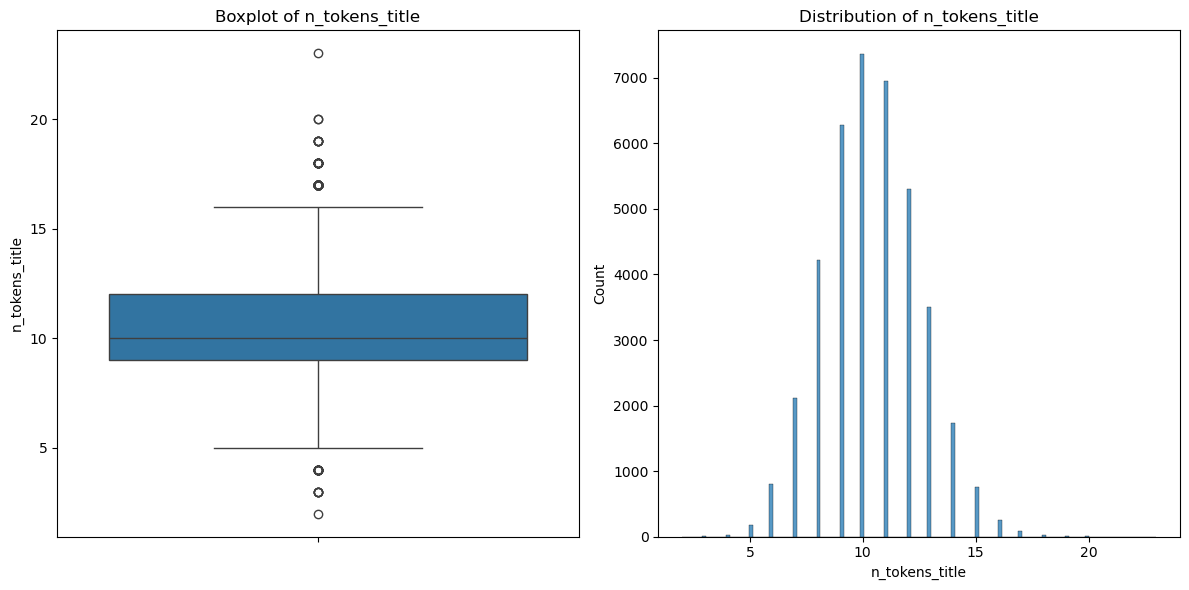

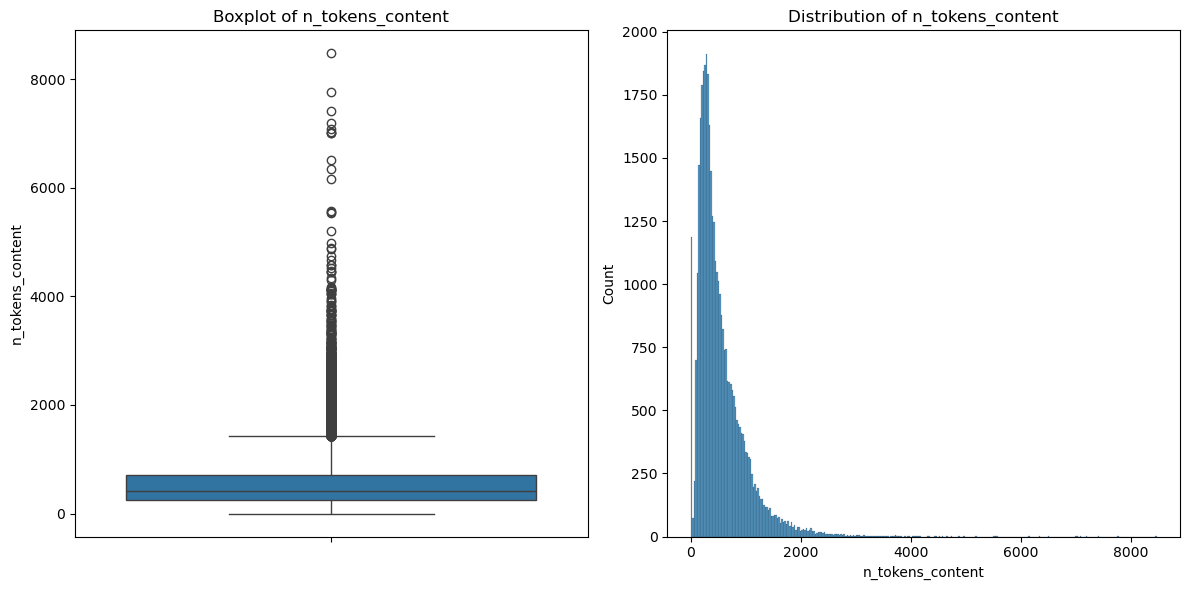

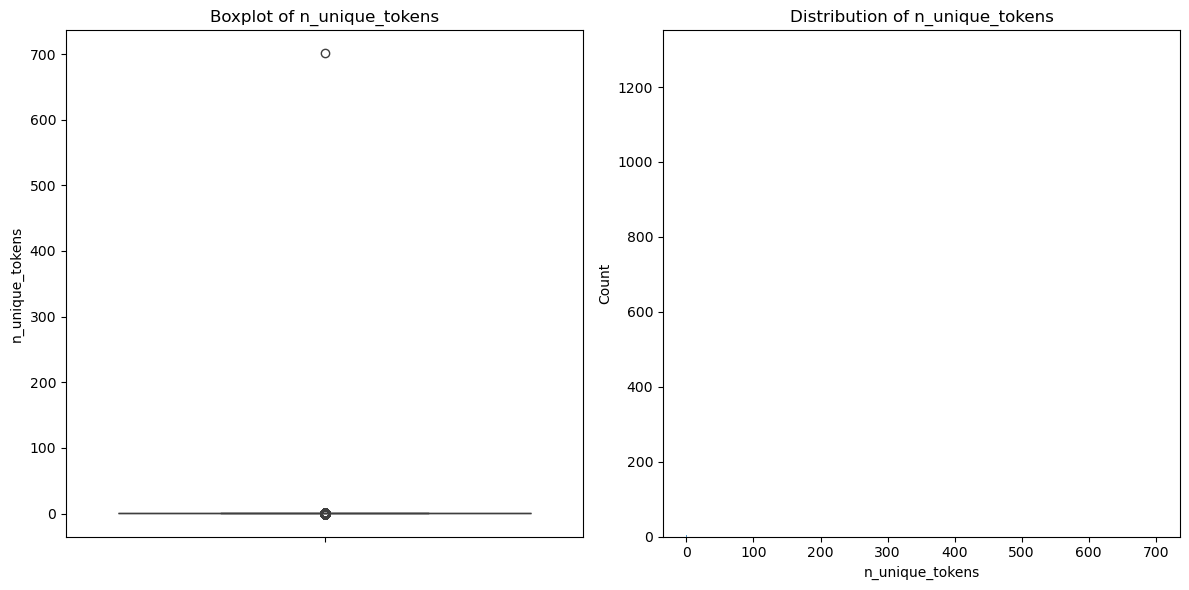

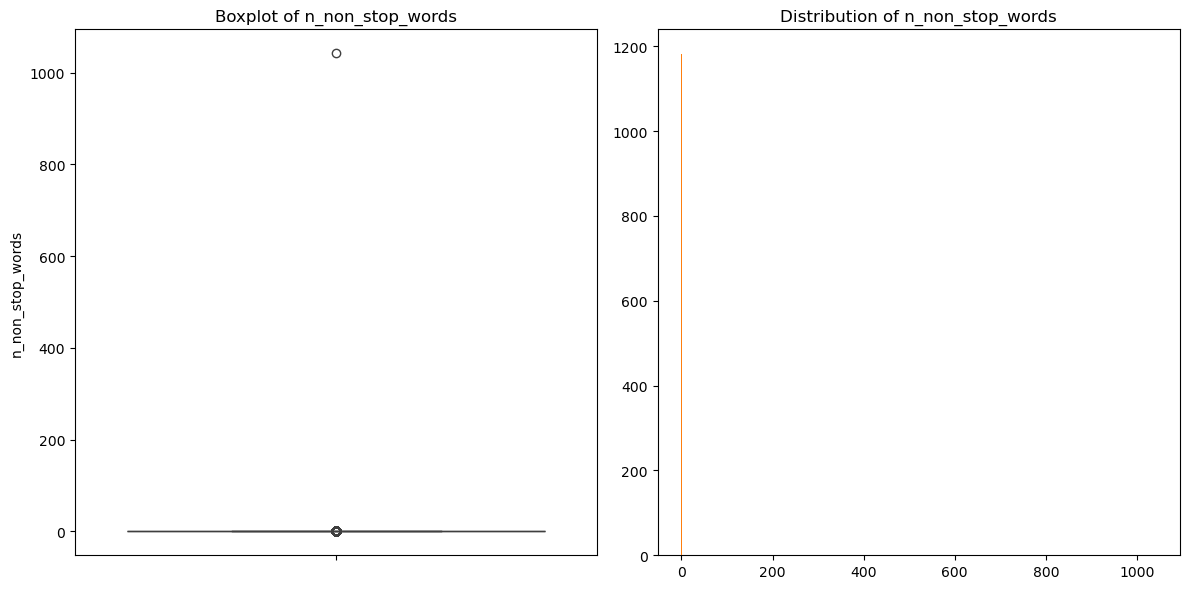

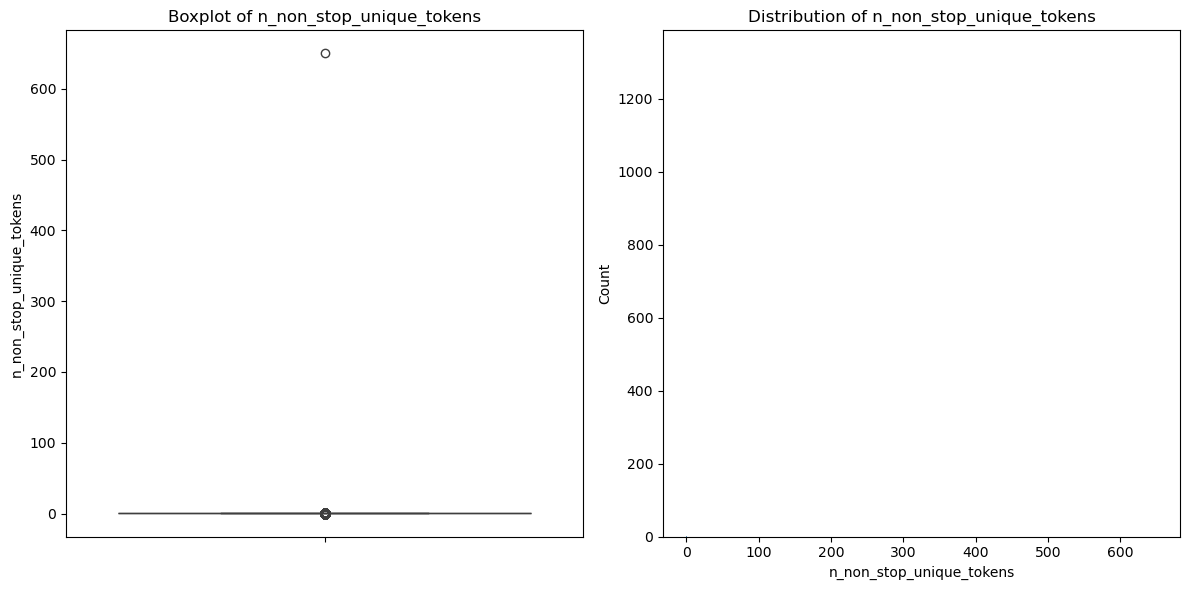

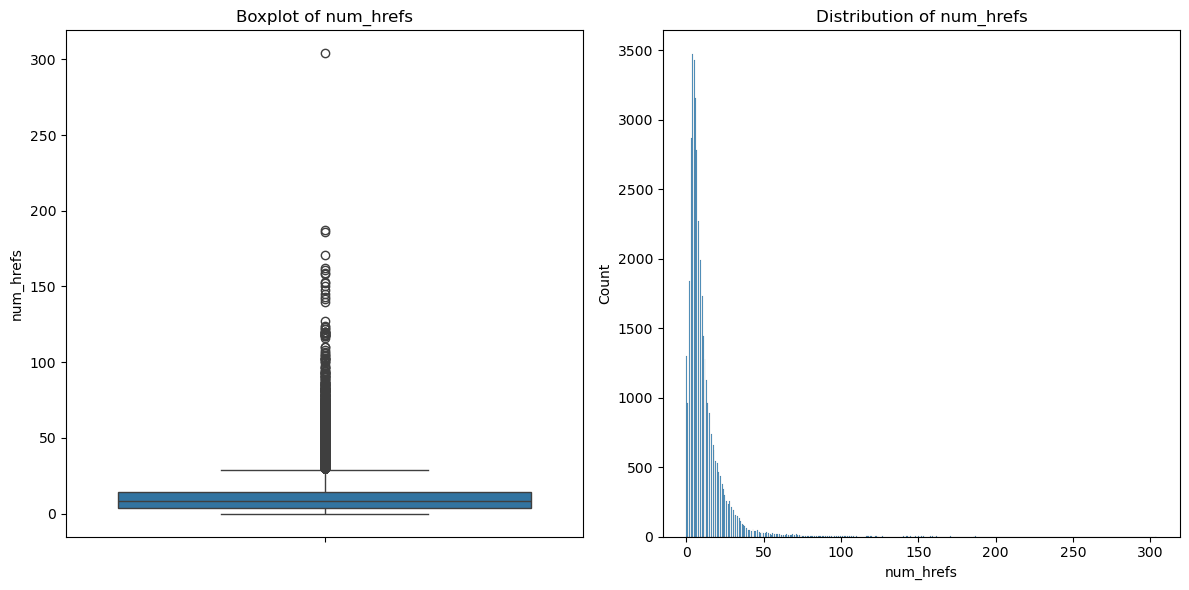

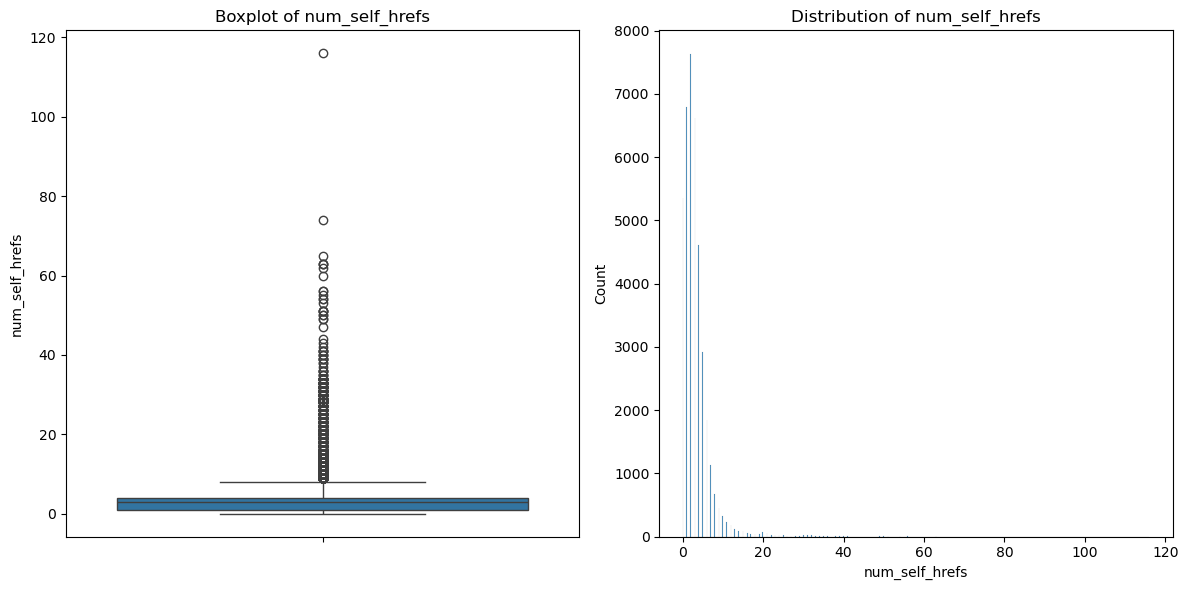

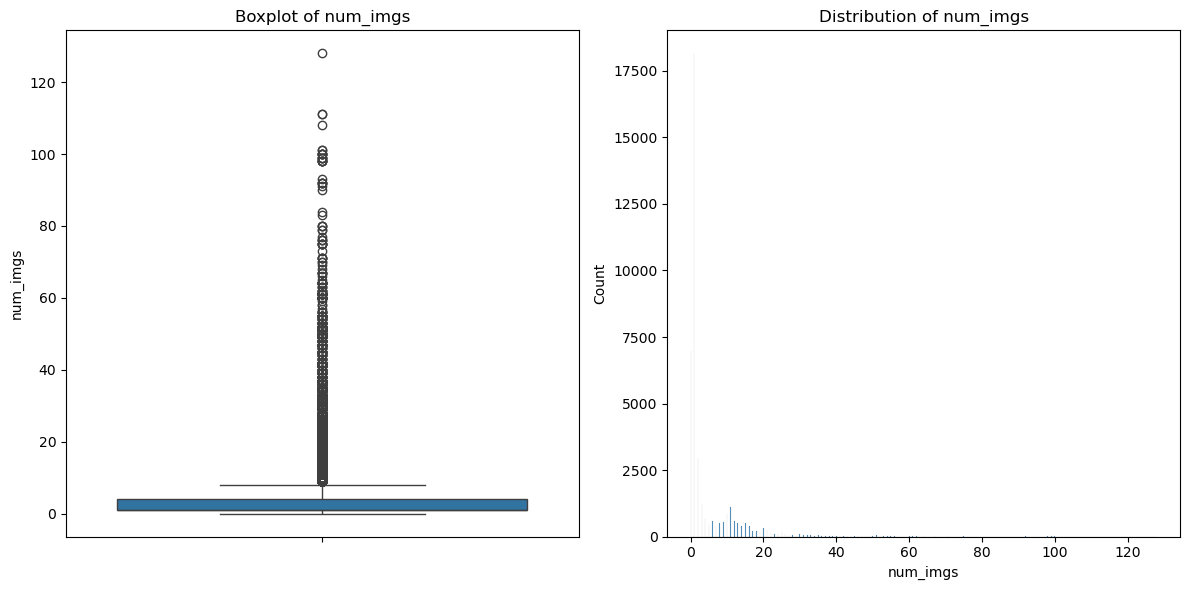

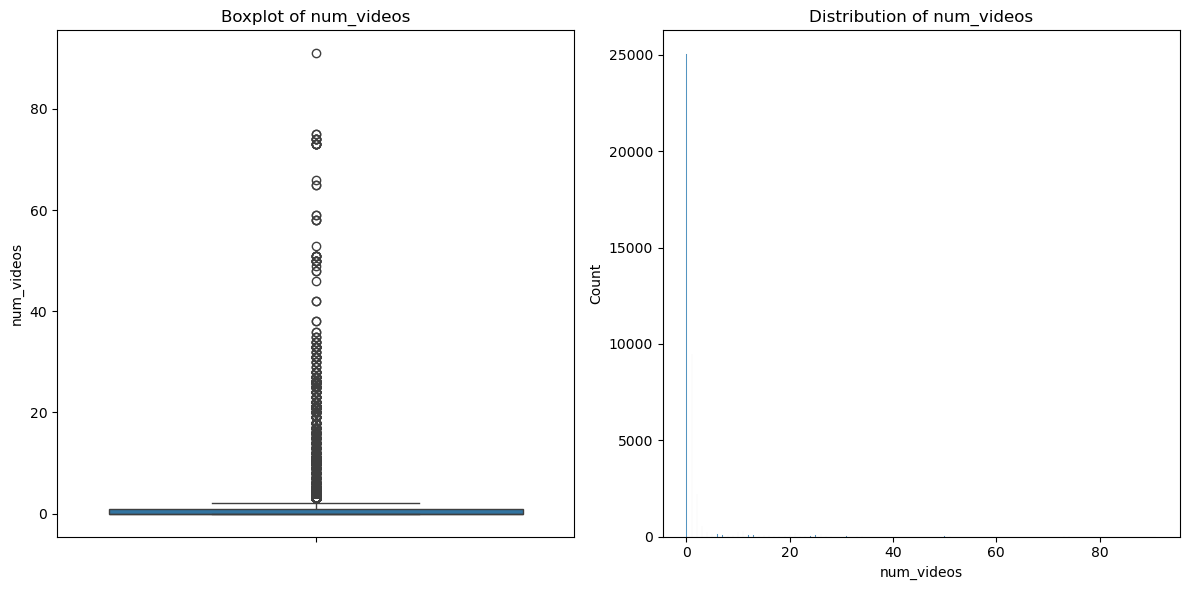

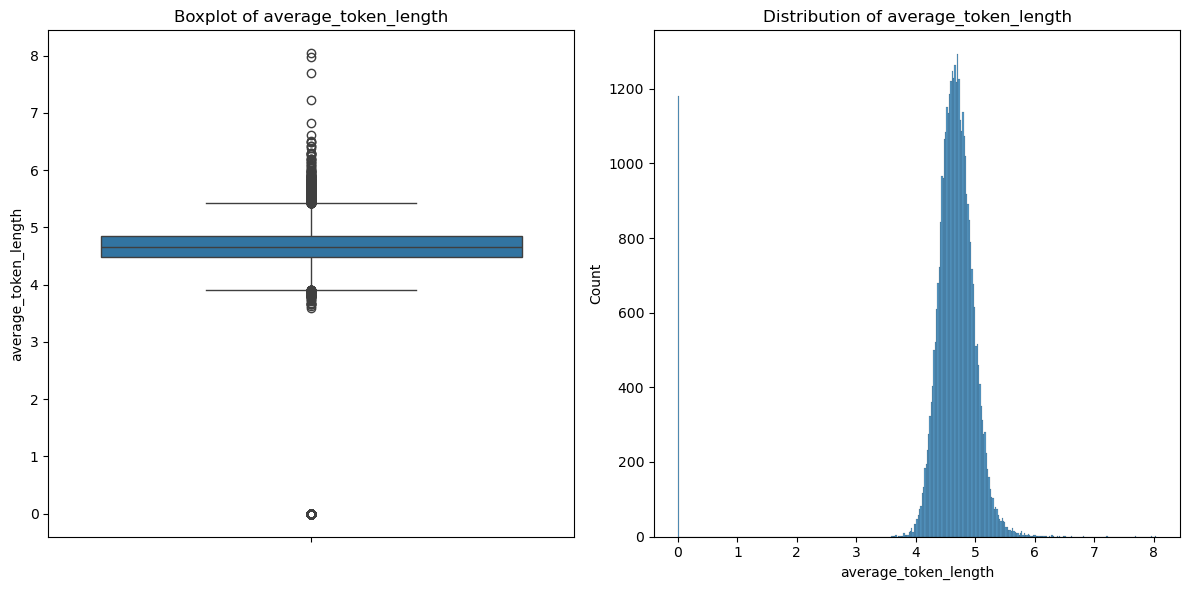

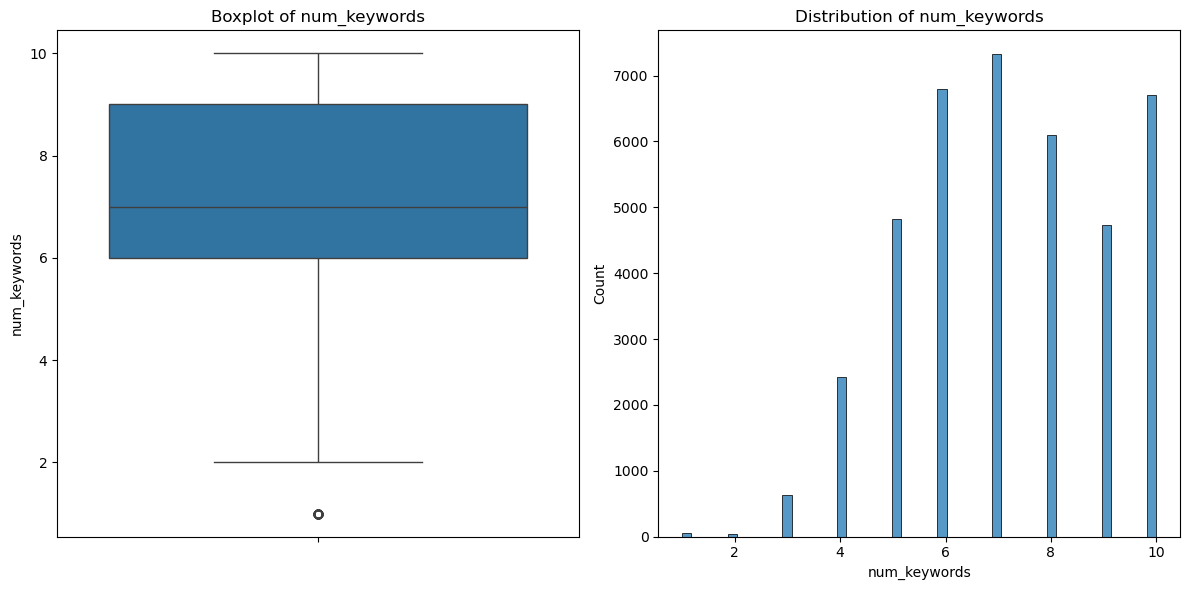

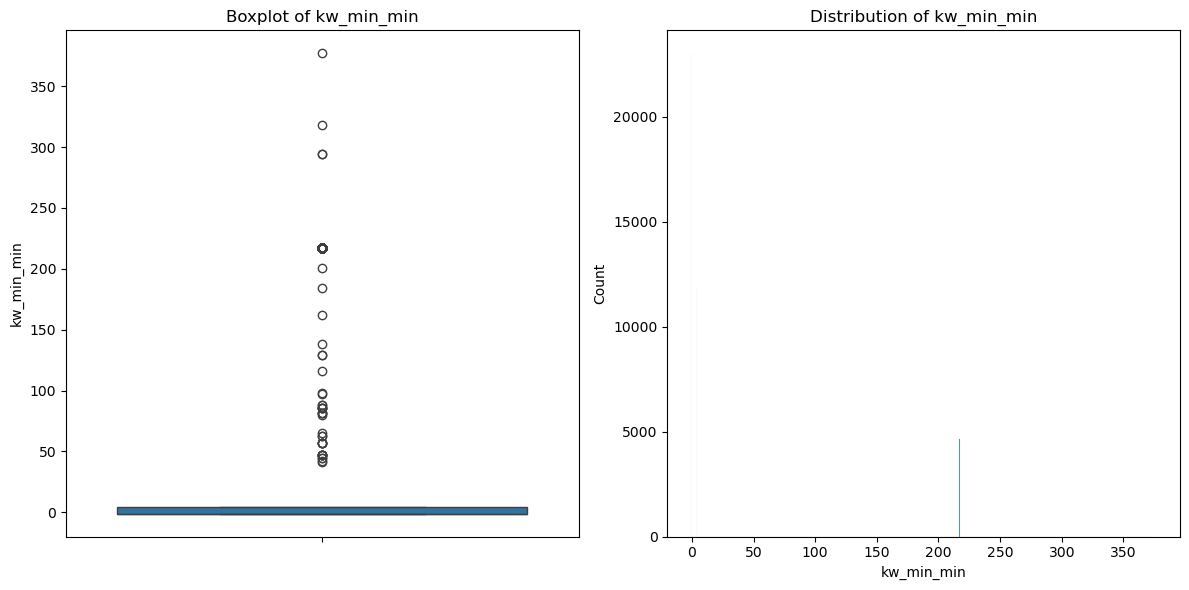

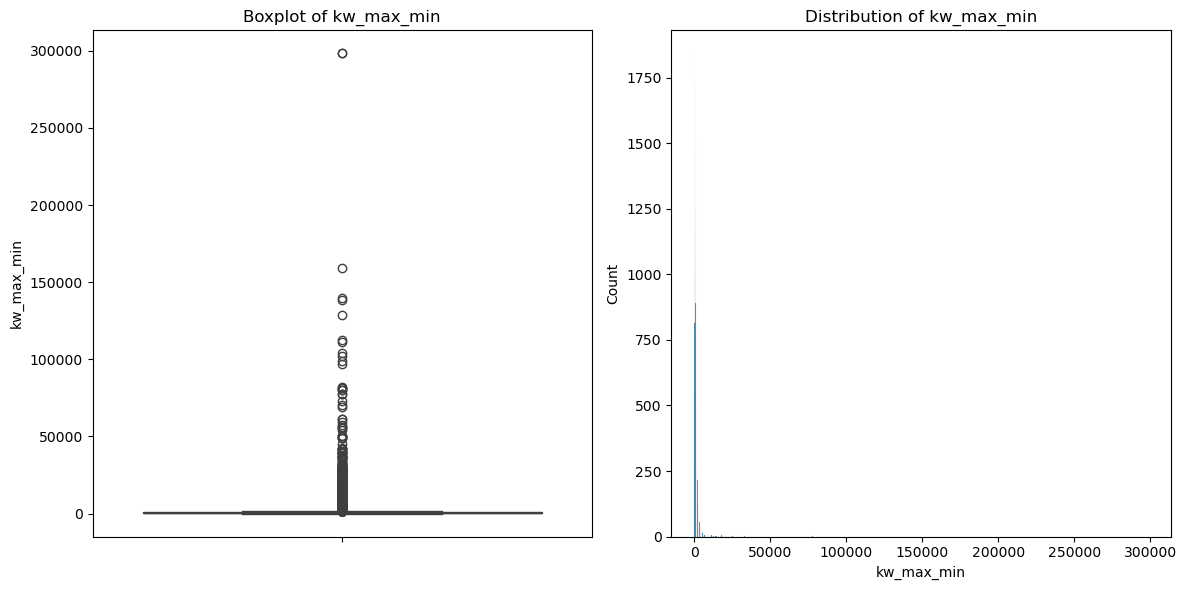

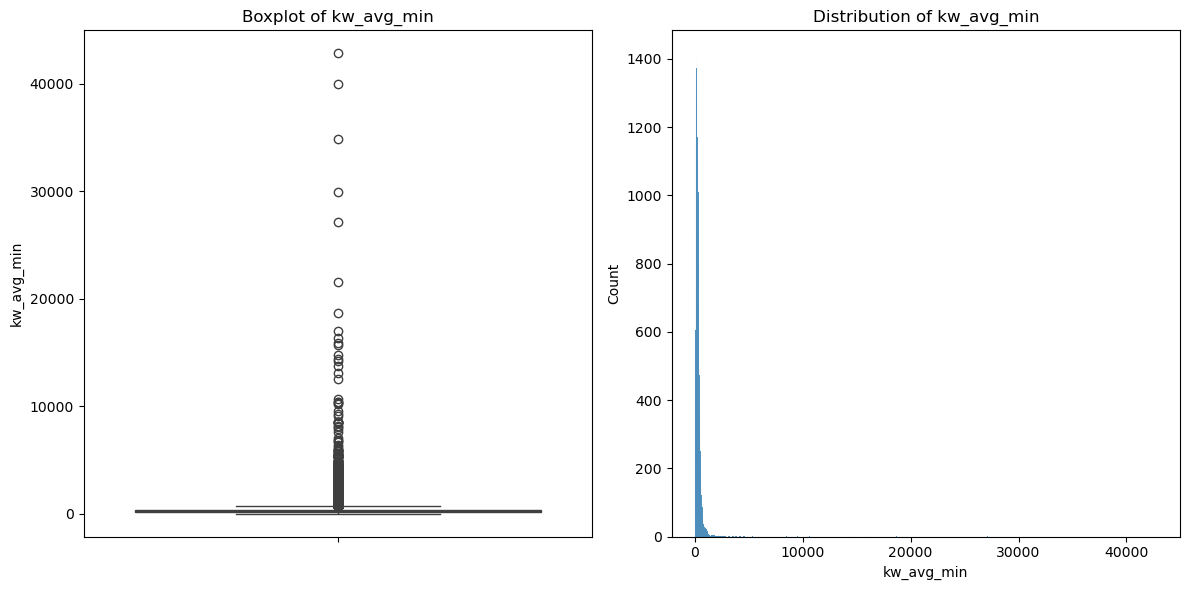

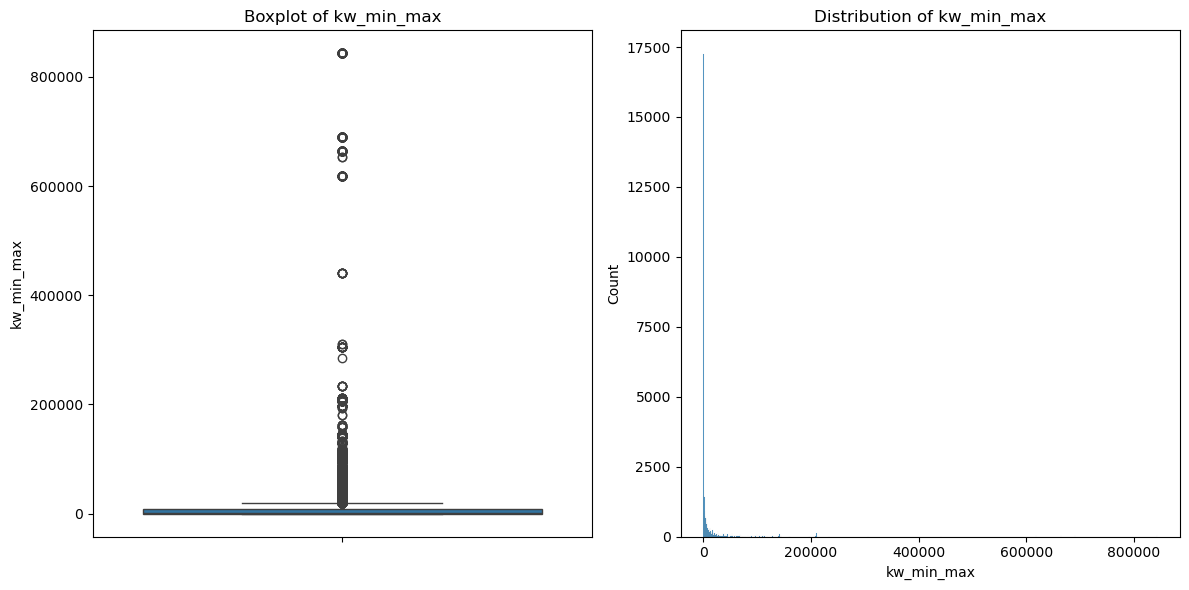

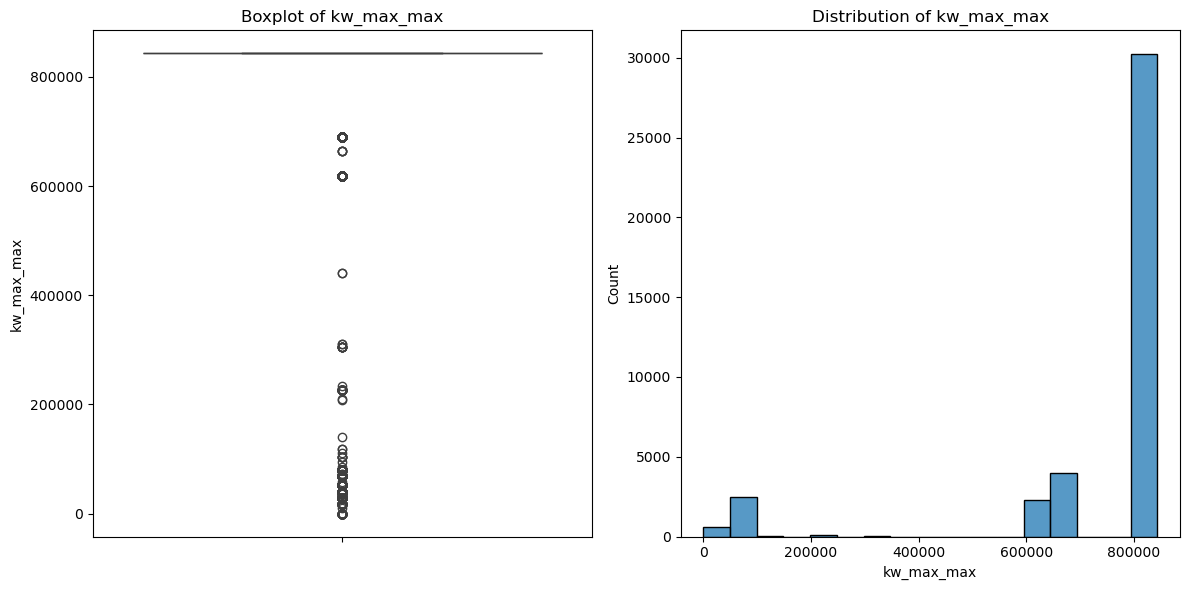

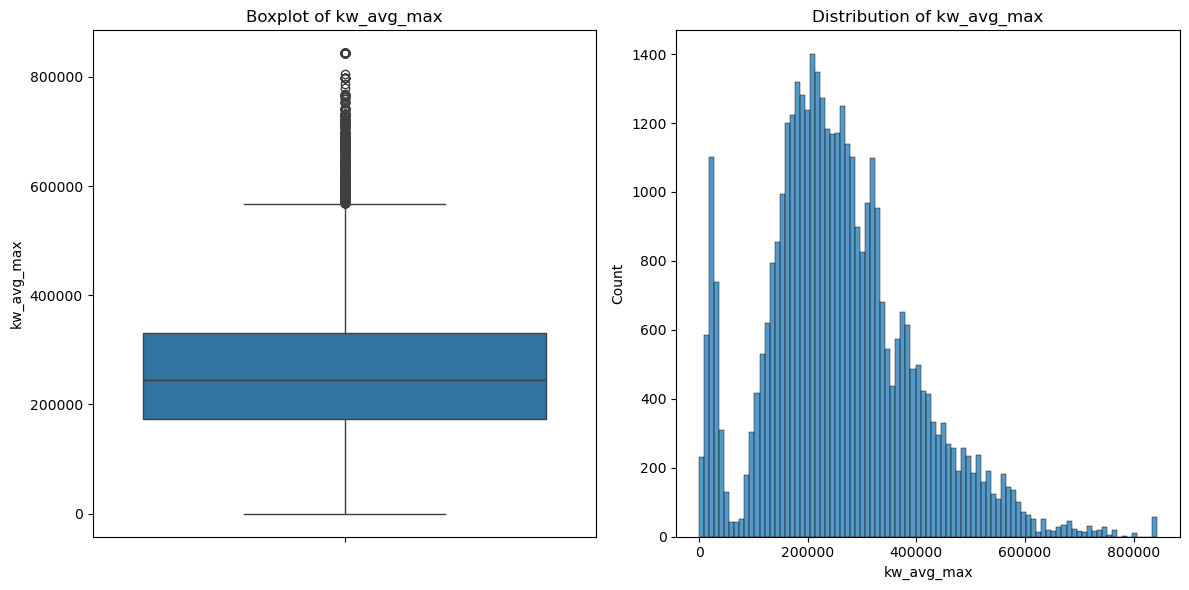

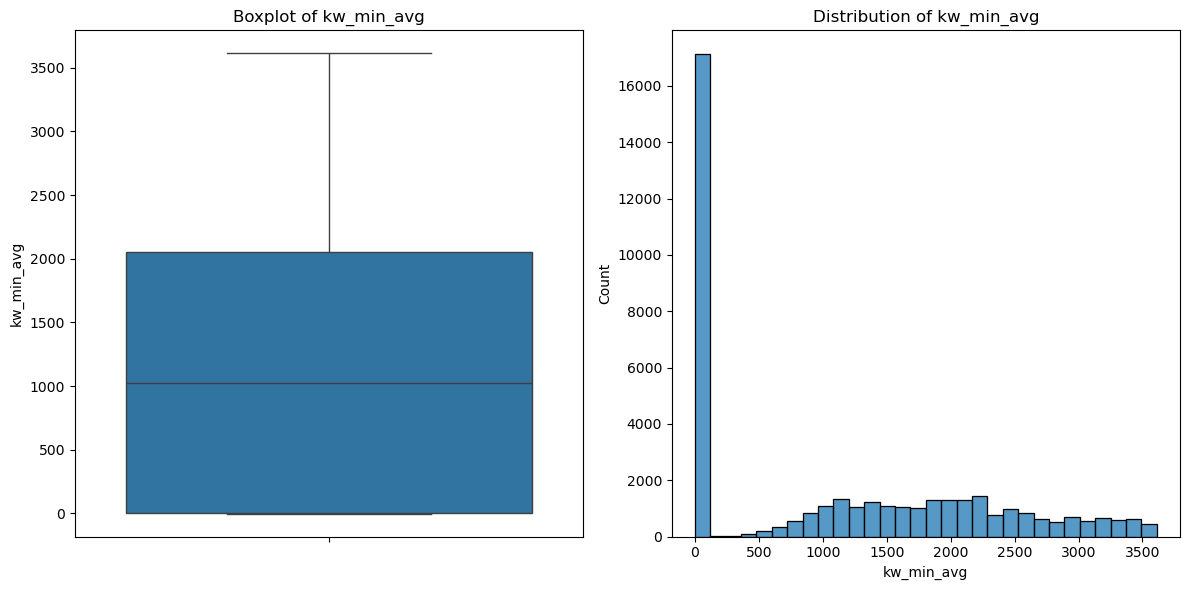

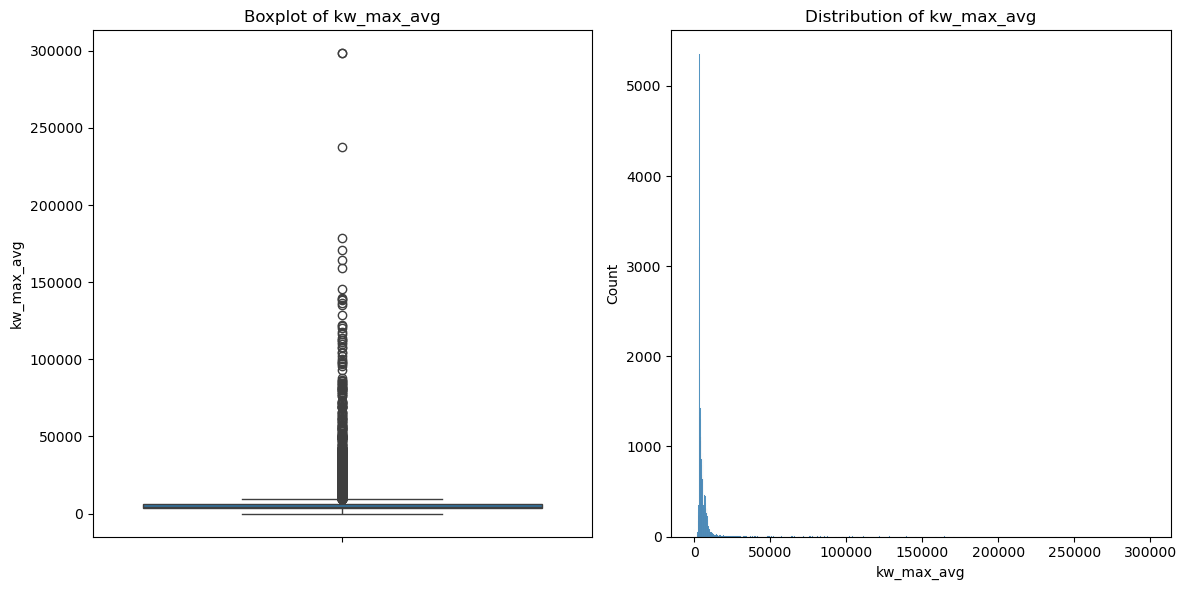

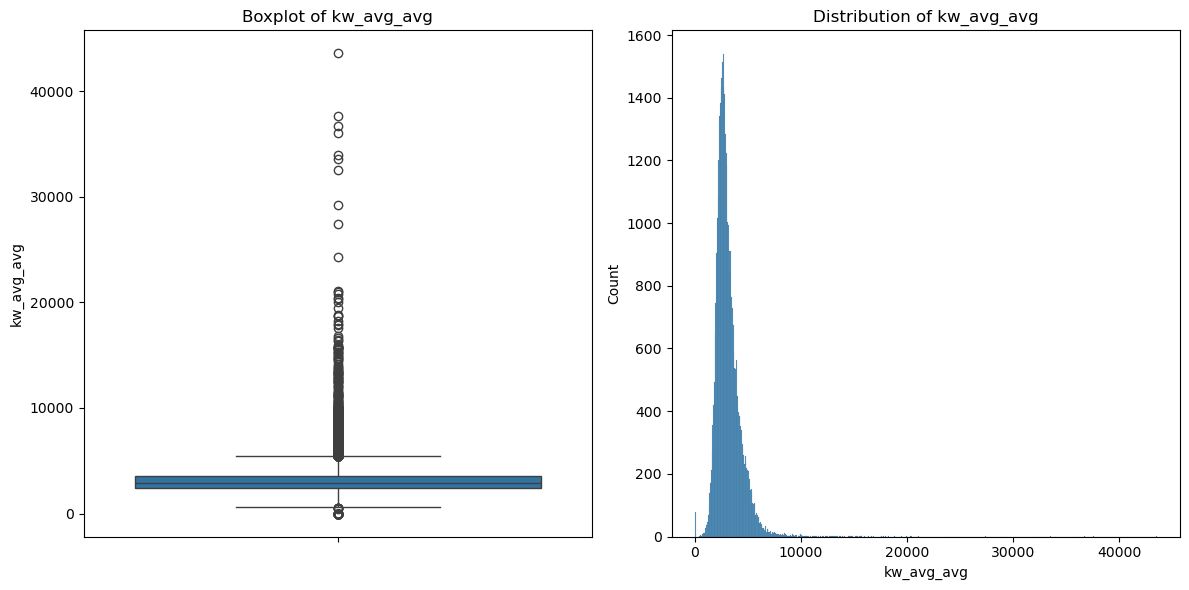

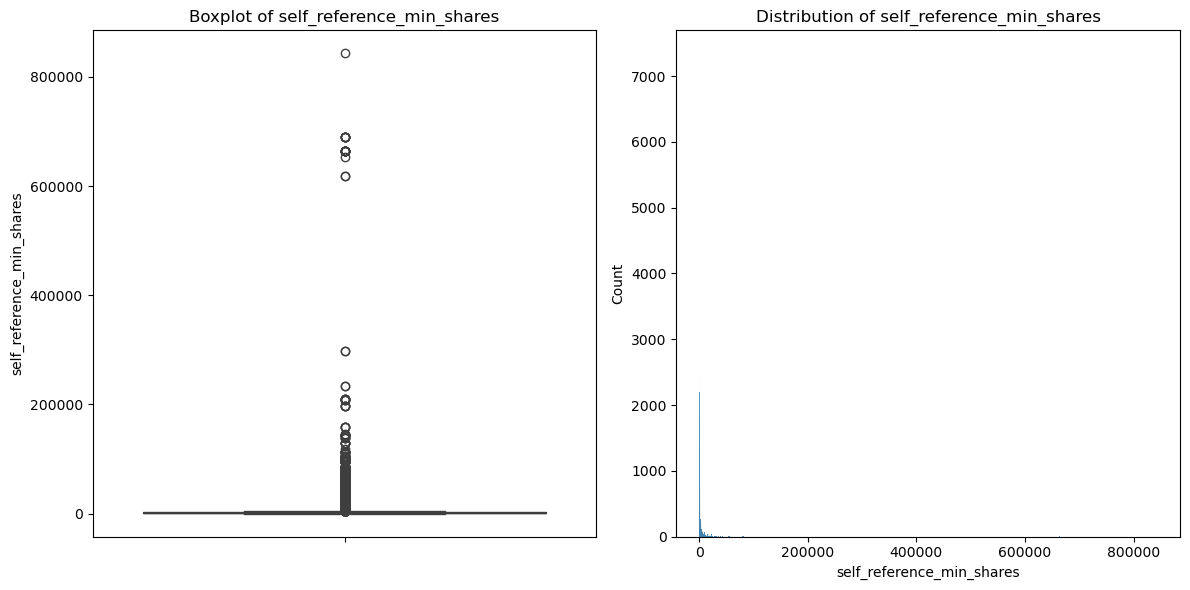

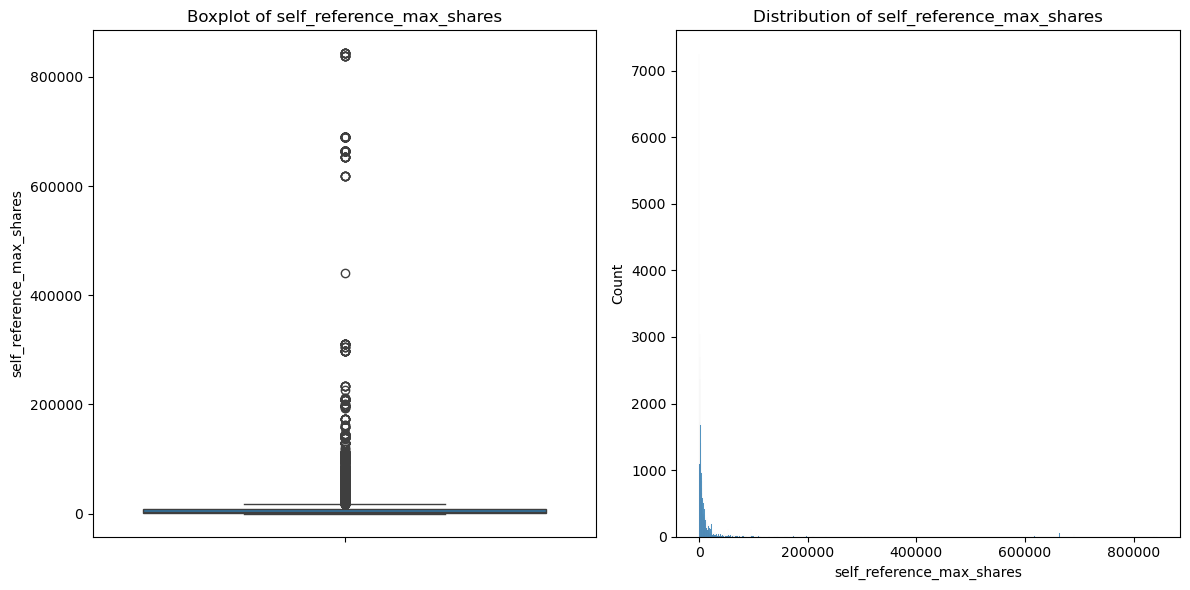

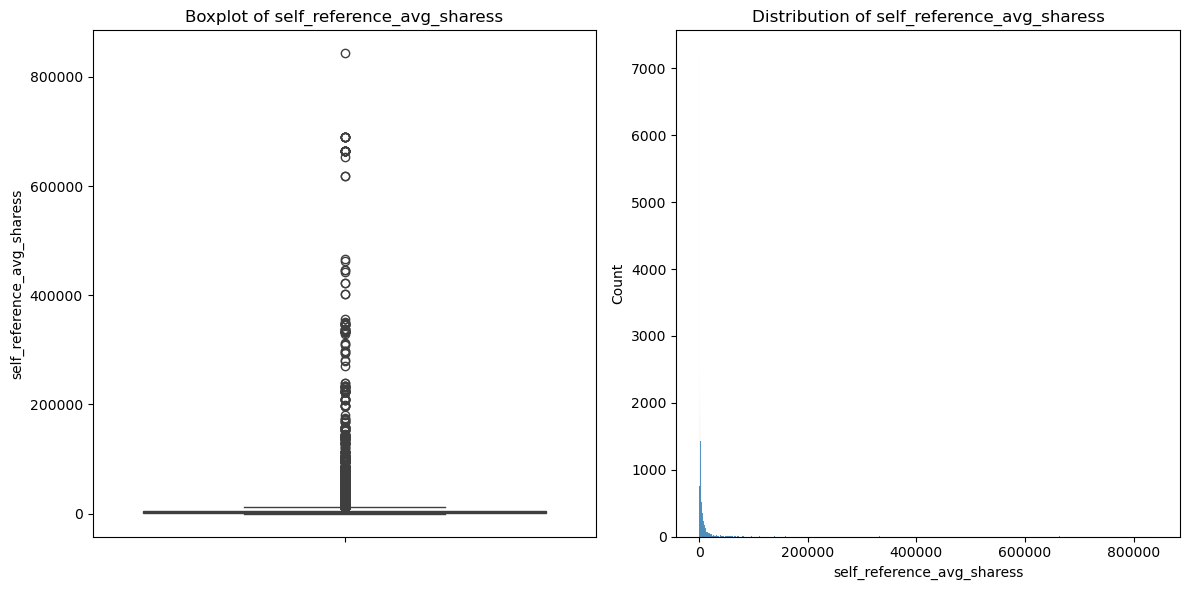

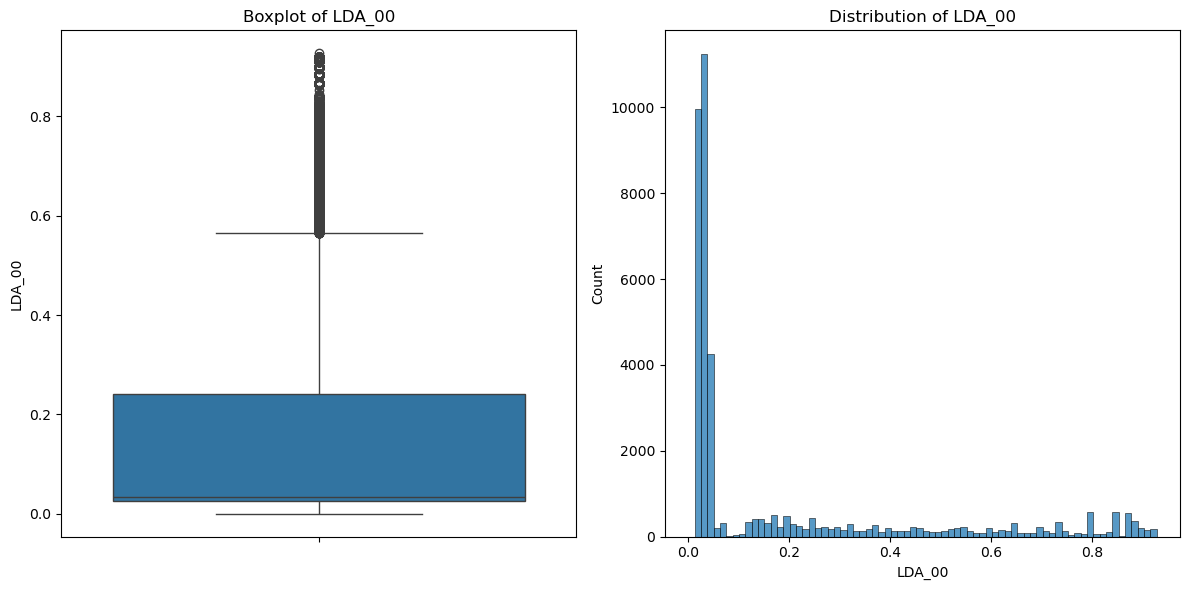

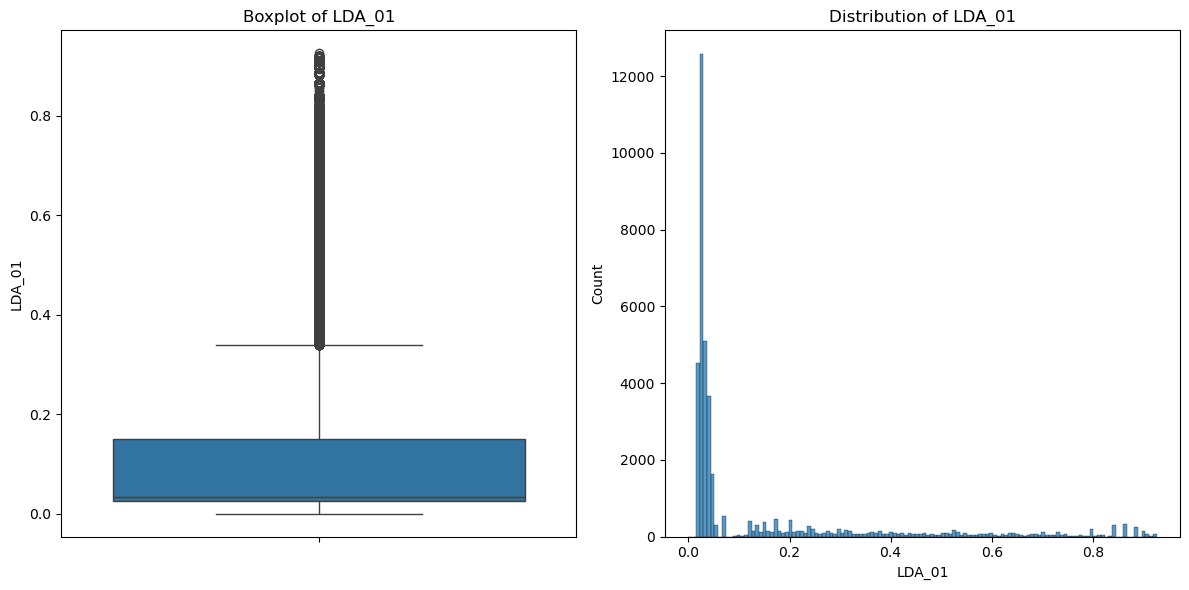

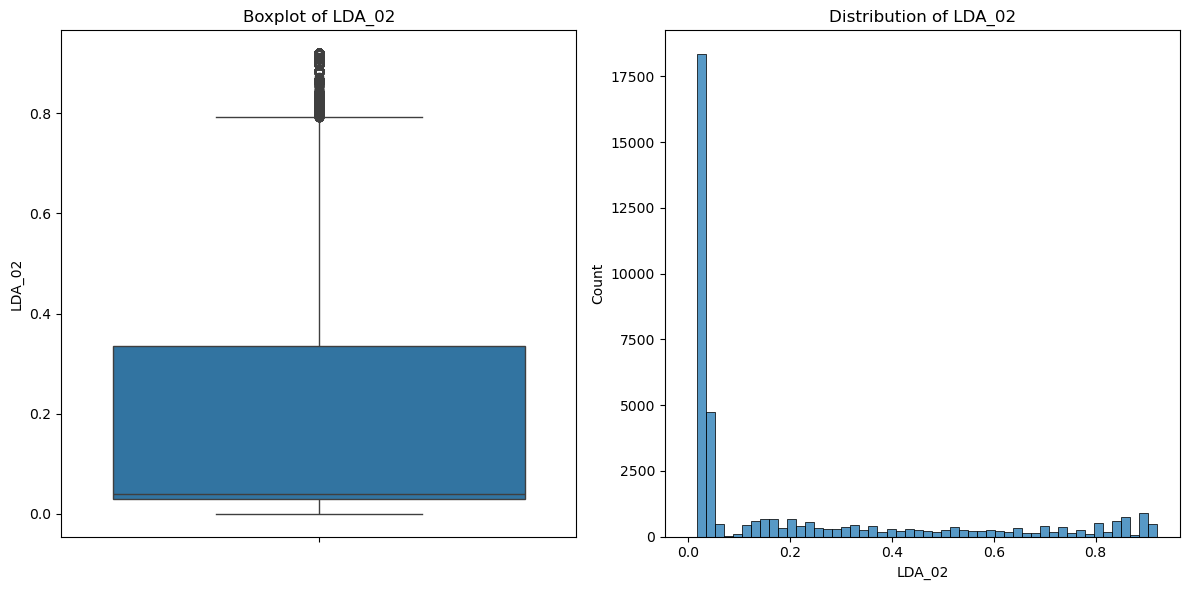

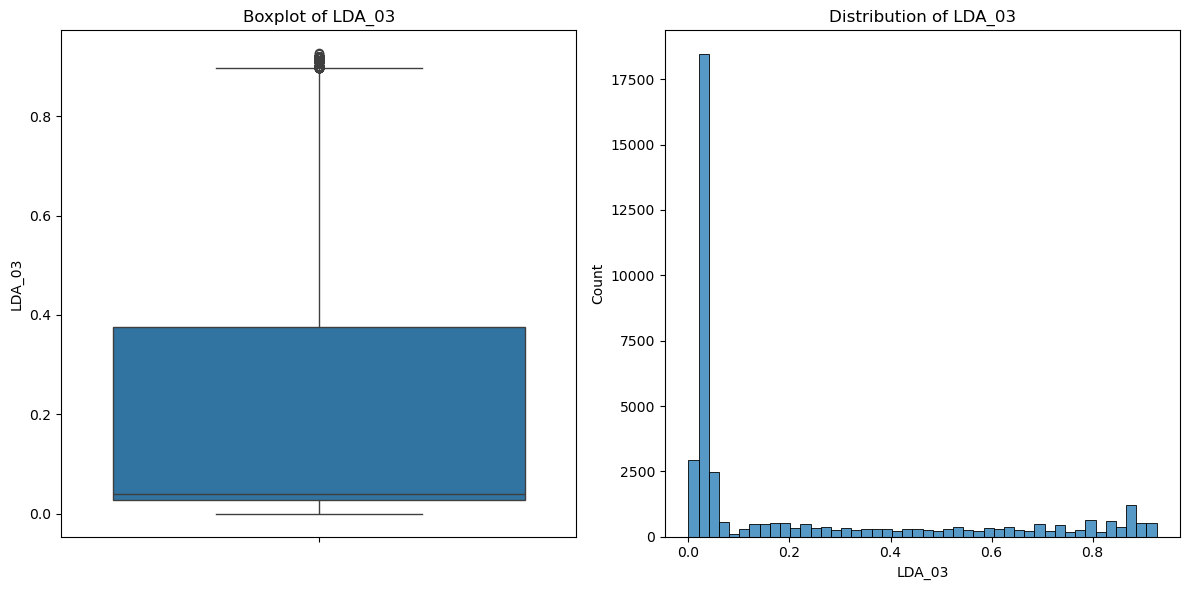

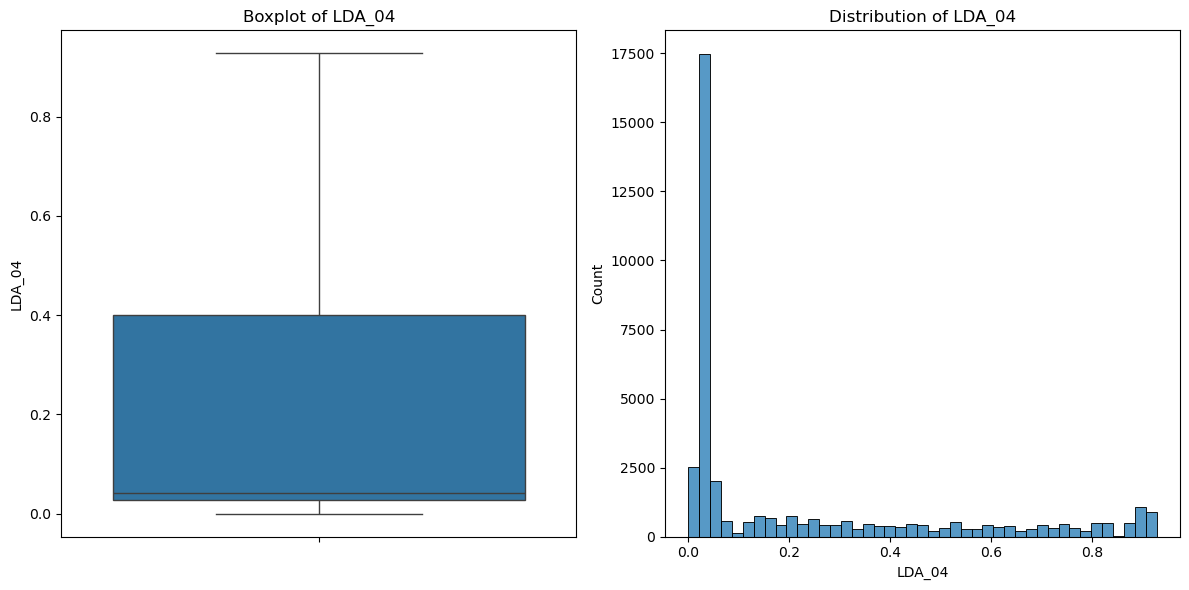

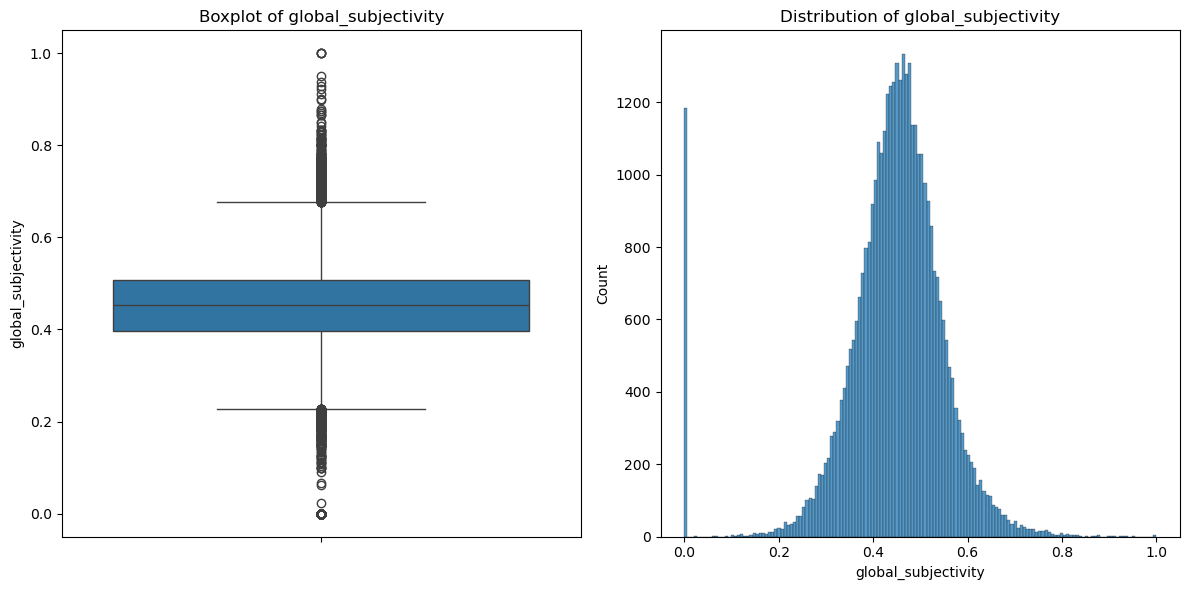

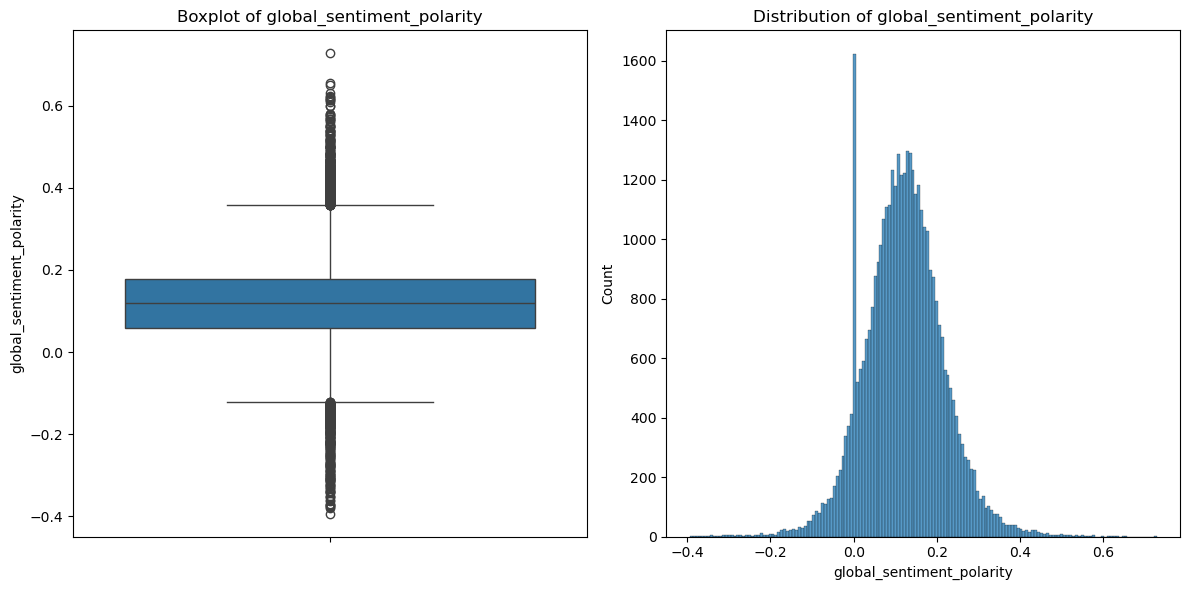

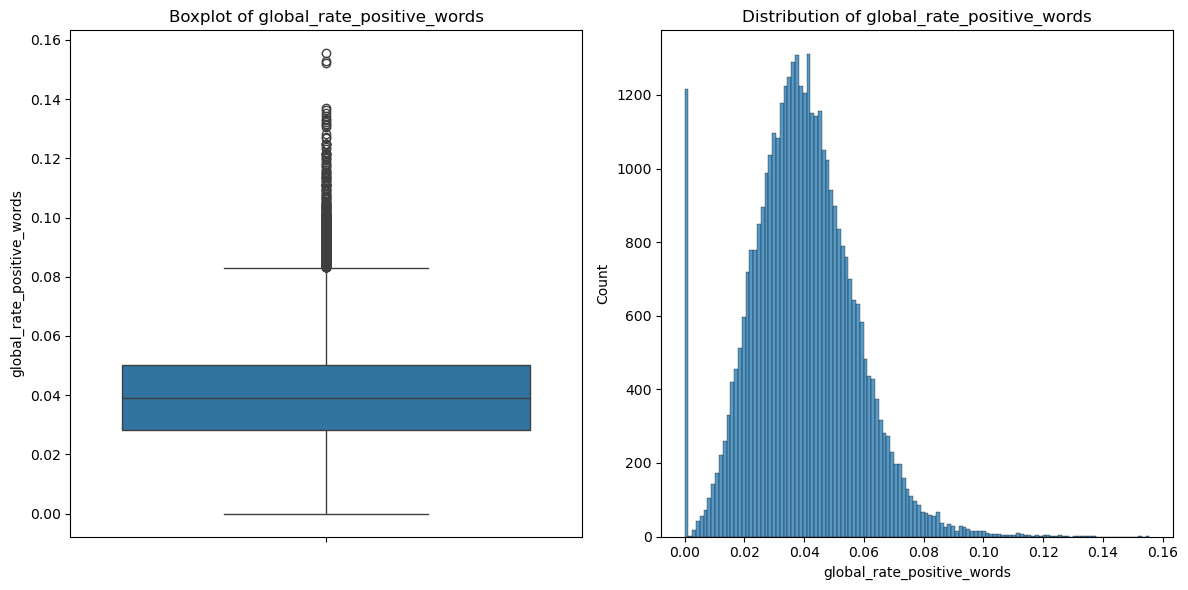

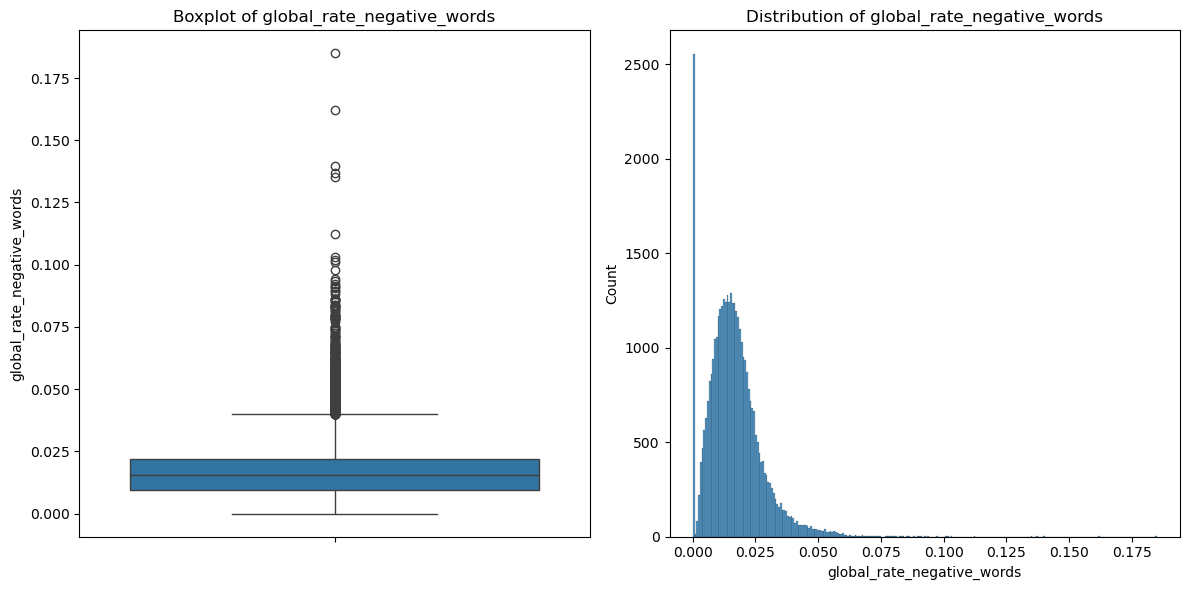

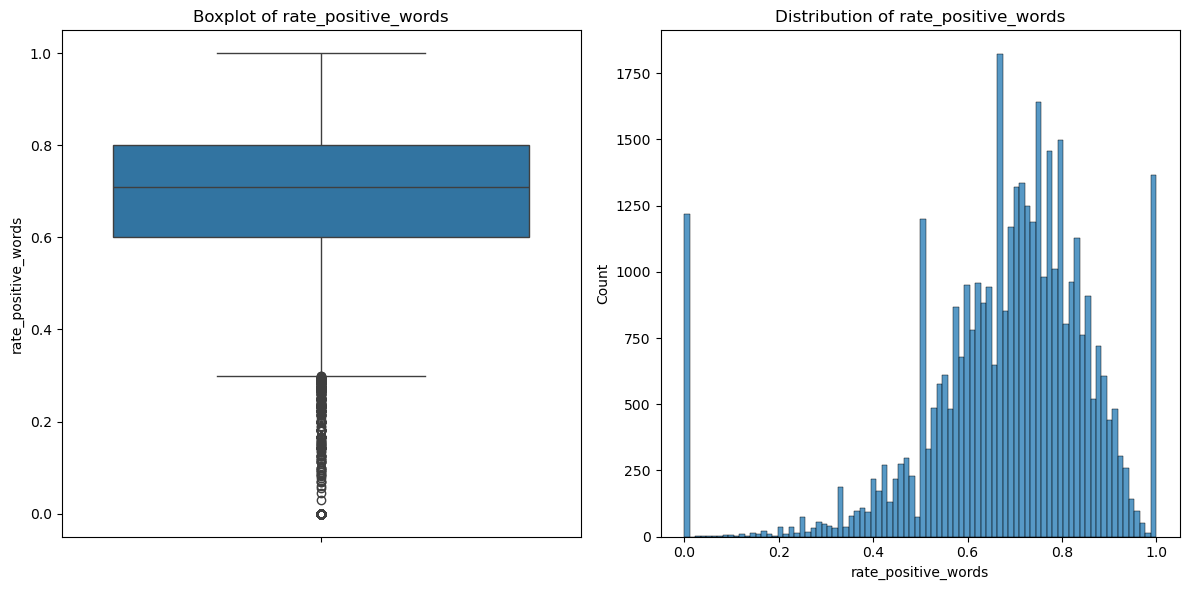

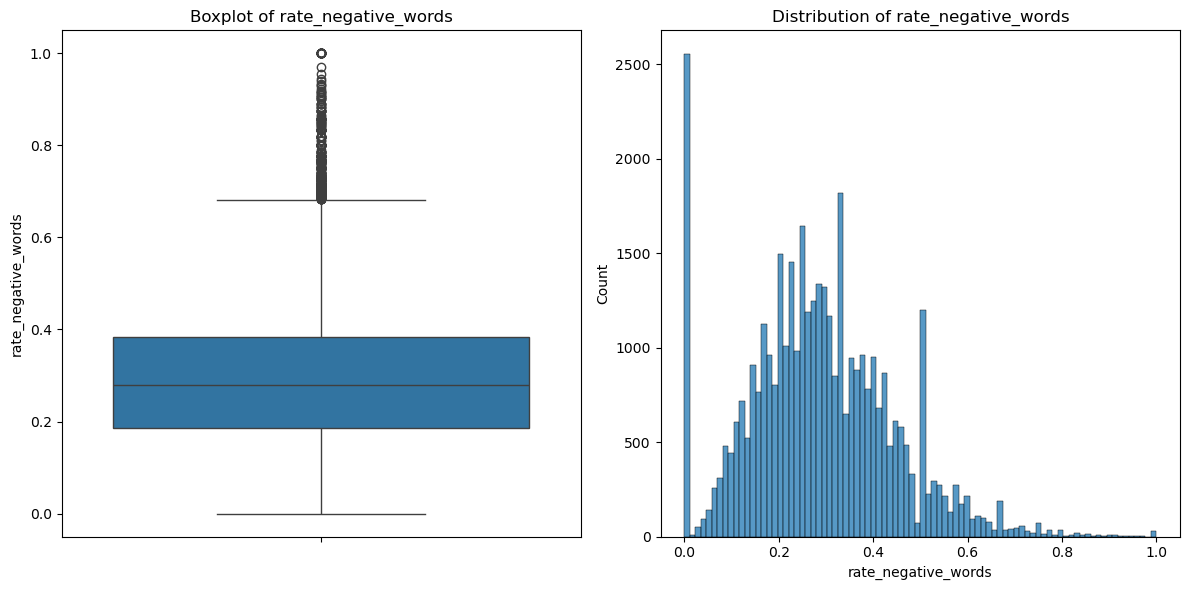

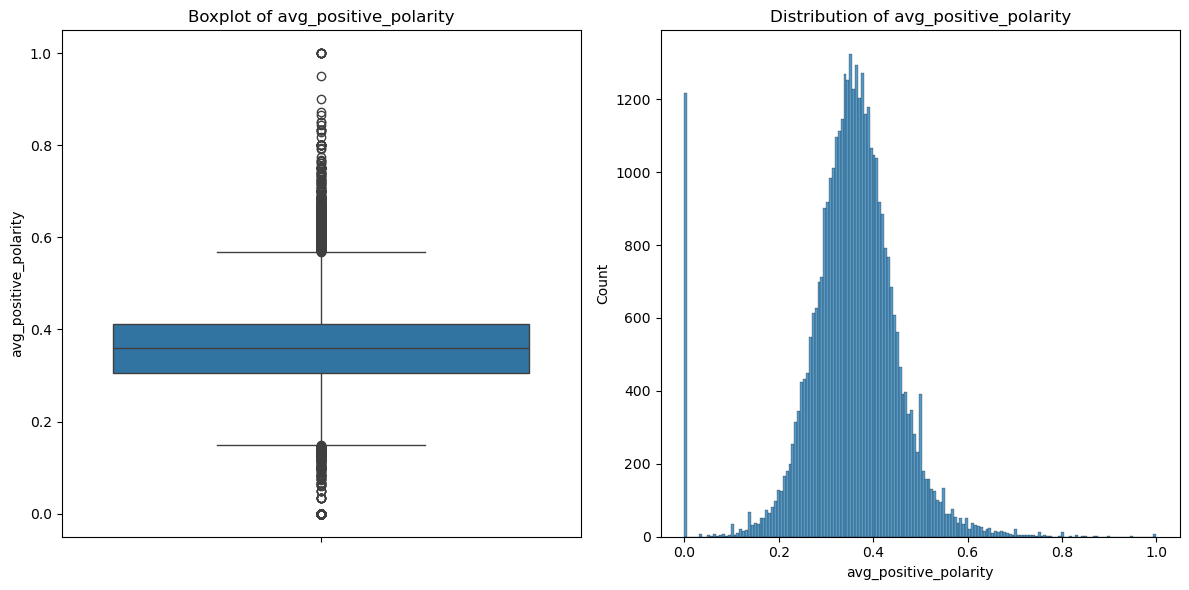

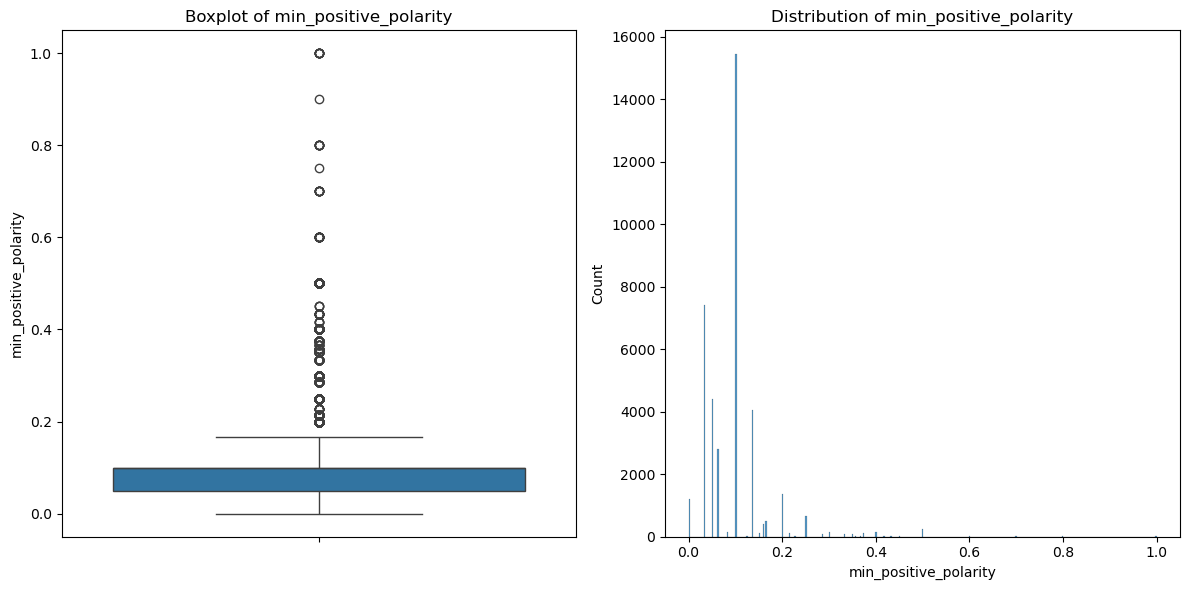

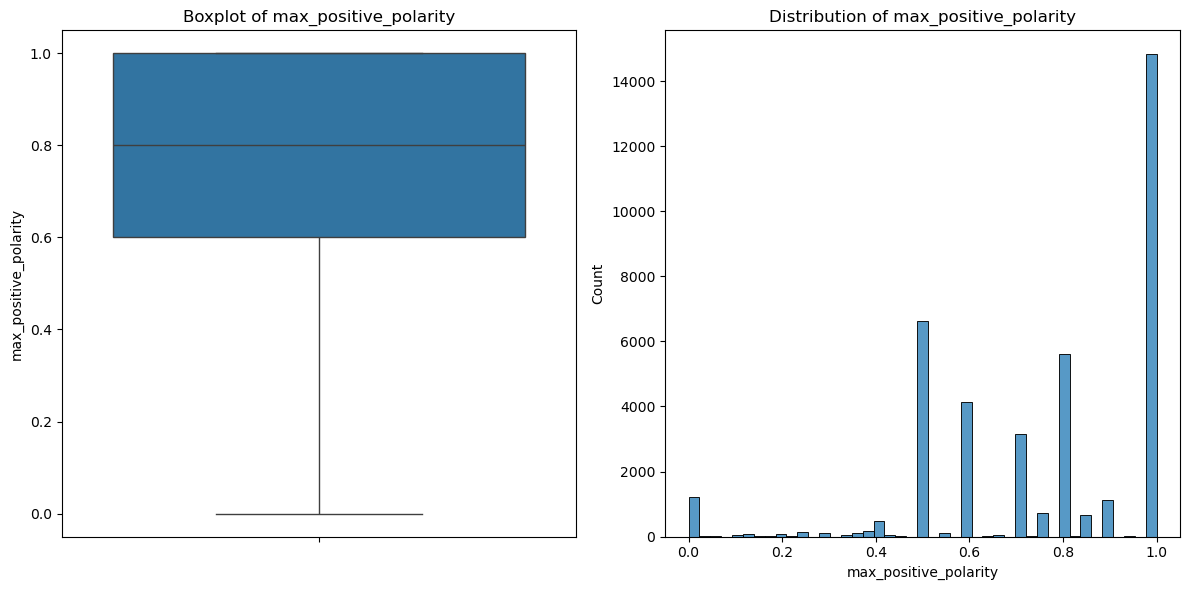

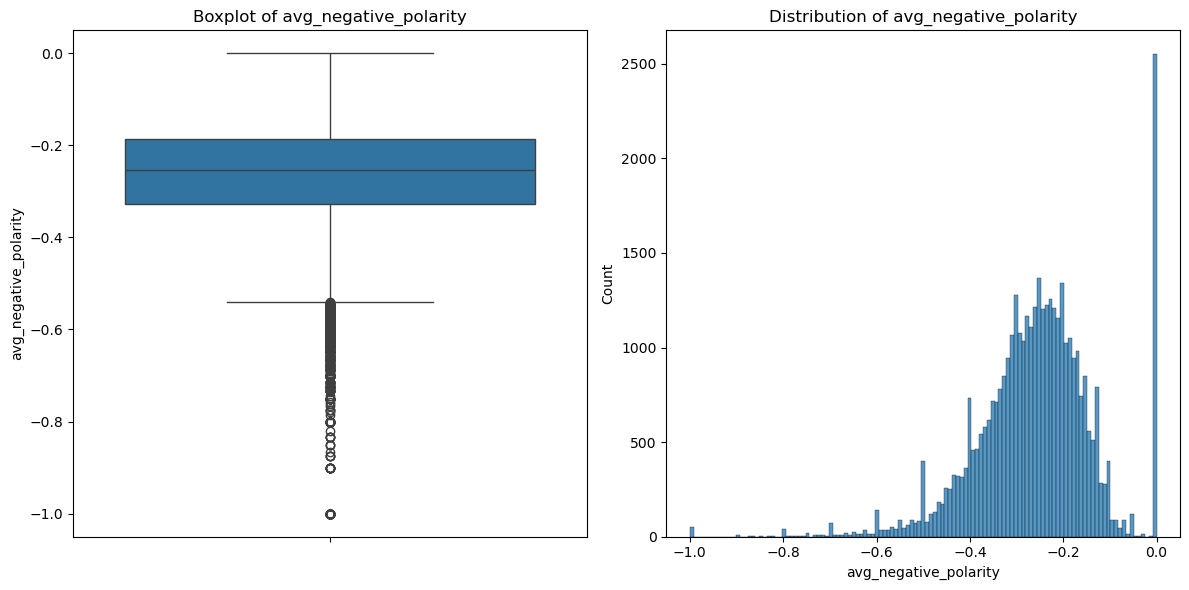

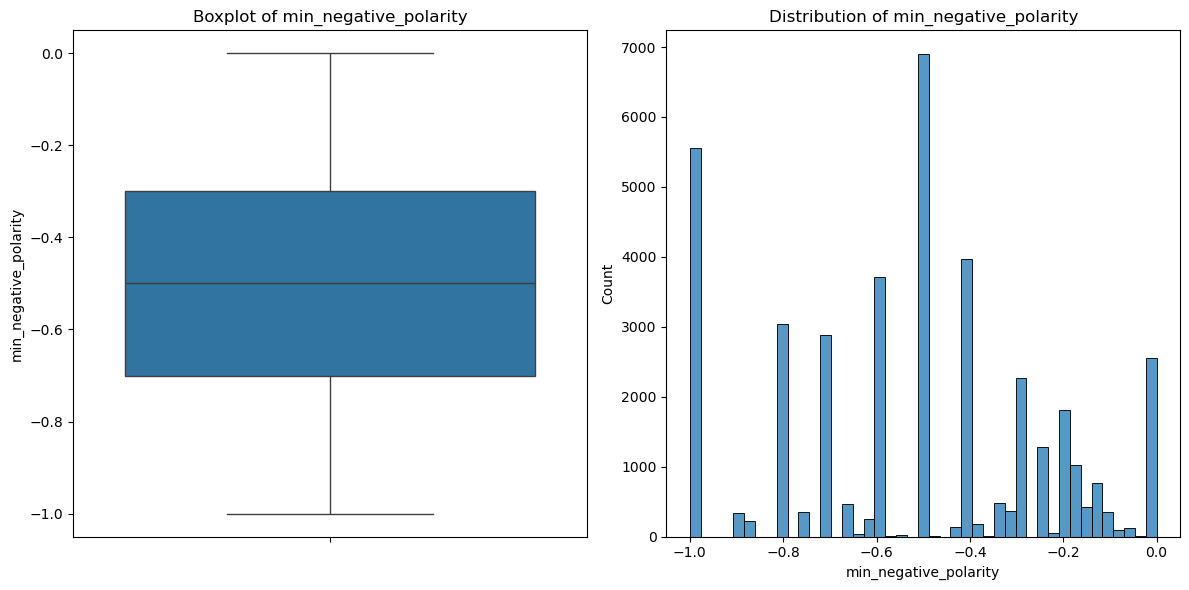

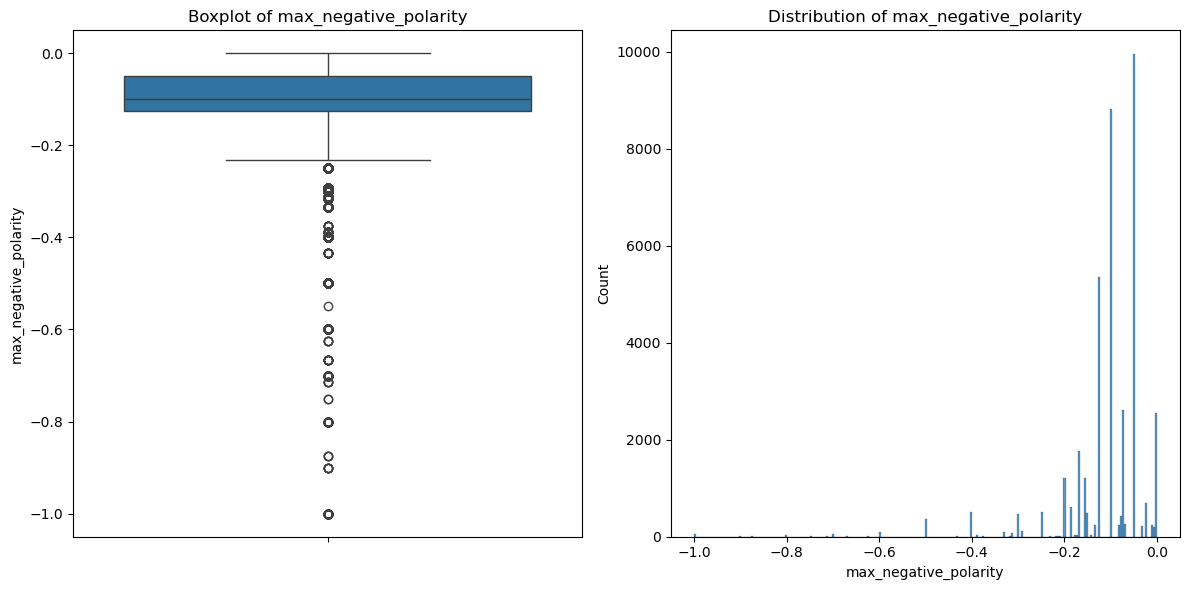

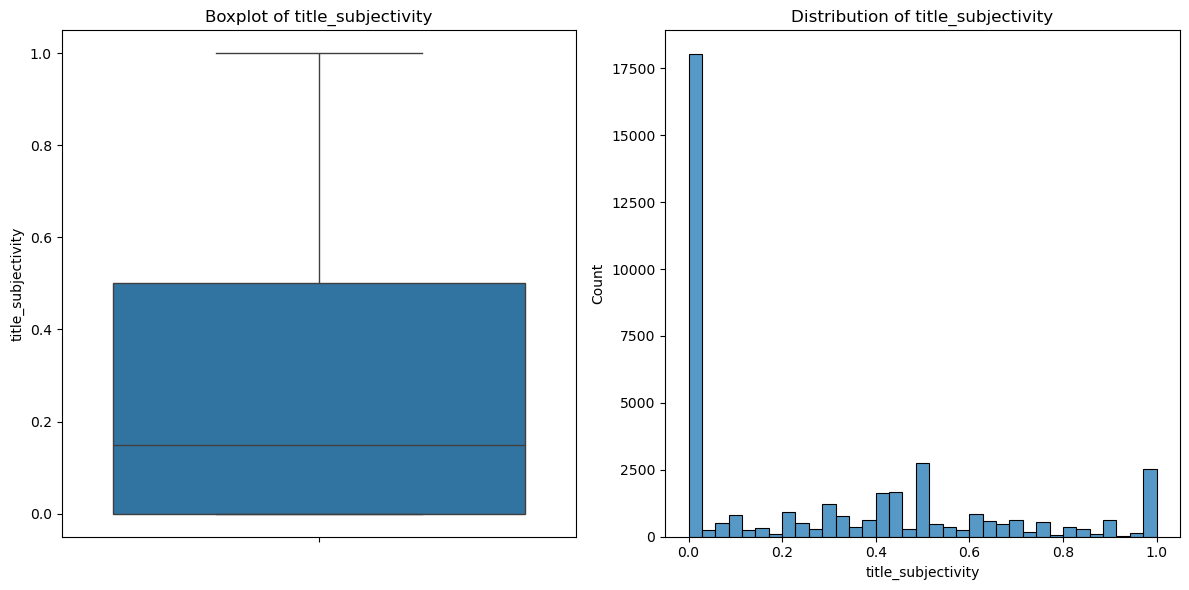

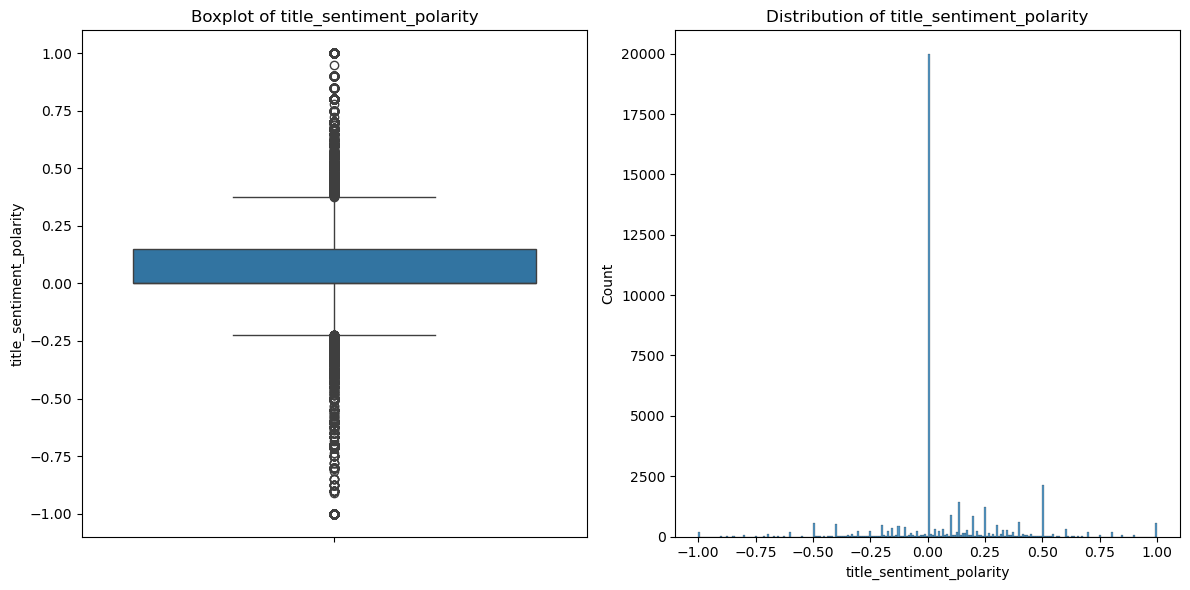

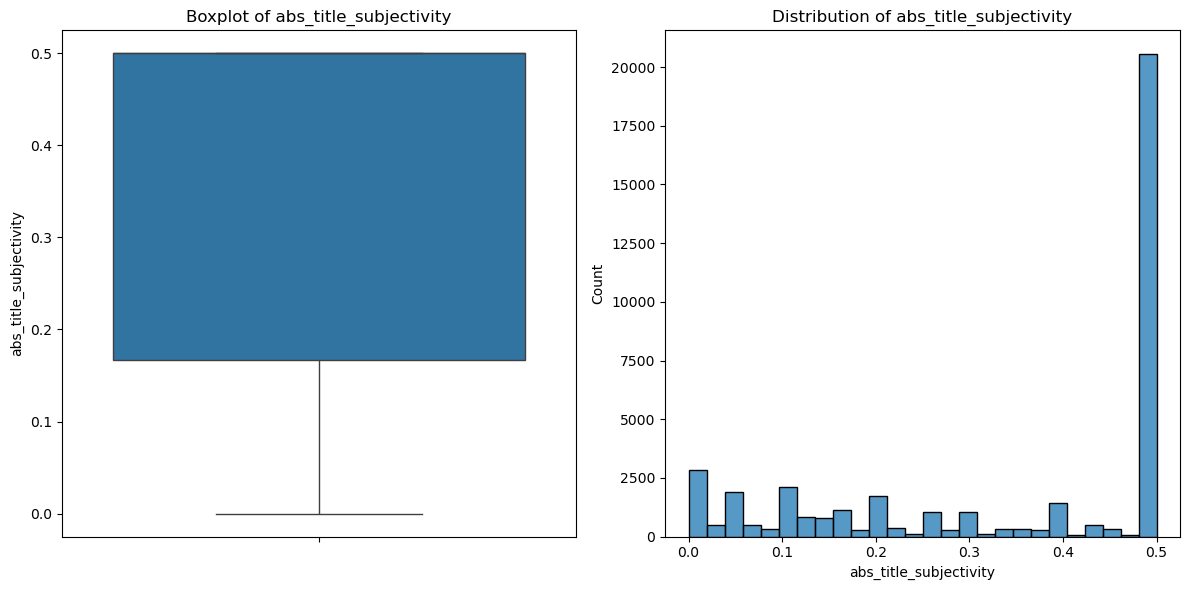

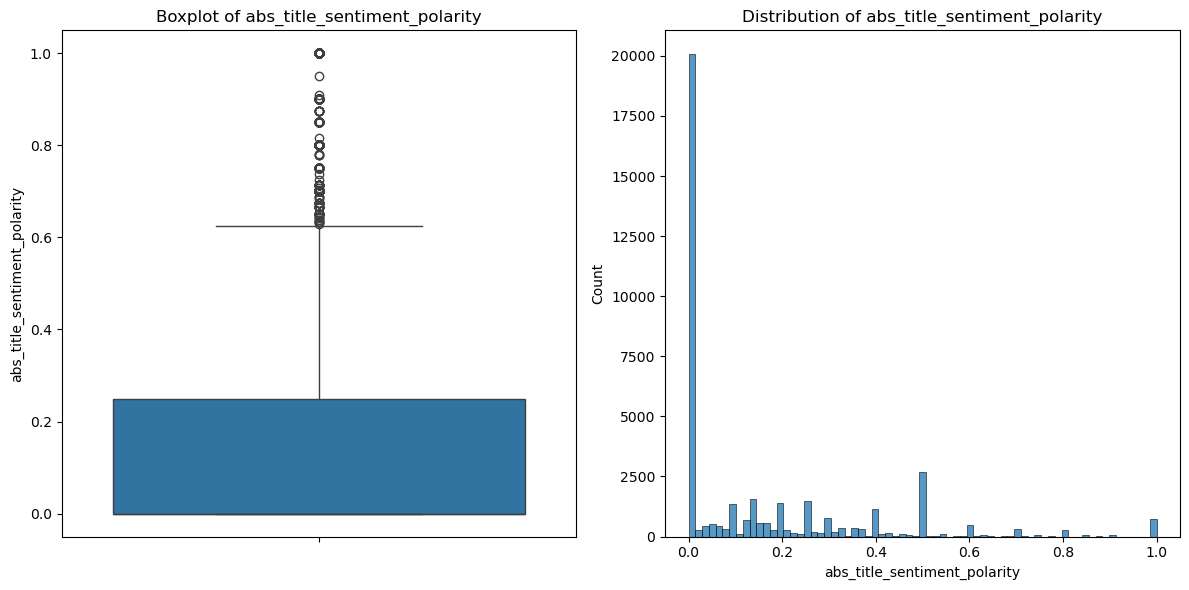

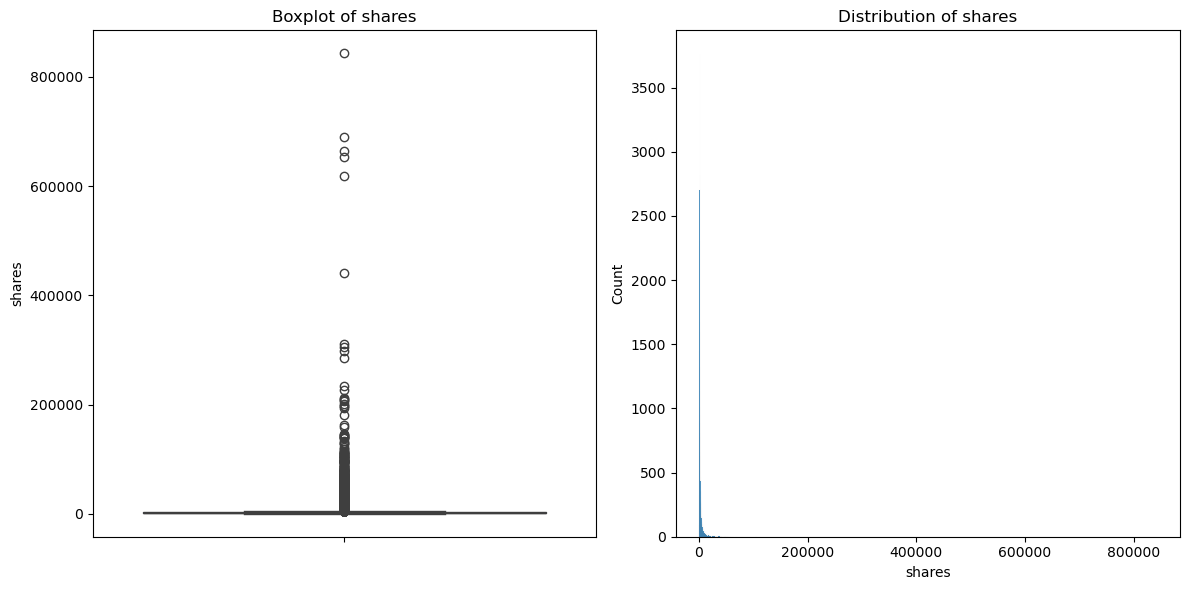

                       feature  iqr_outliers  z_outliers  total_rows  \
16                  kw_max_max          9440        3096       39644   
8                     num_imgs          7703         863       39644   
42    title_sentiment_polarity          7592         914       39644   
25                      LDA_01          5834        1303       39644   
24                      LDA_00          5282           0       39644   
15                  kw_min_max          5063         469       39644   
21   self_reference_min_shares          4976         270       39644   
12                  kw_min_min          4677           4       39644   
45                      shares          4541         308       39644   
23  self_reference_avg_sharess          4209         321       39644   
22   self_reference_max_shares          4183         256       39644   
13                  kw_max_min          3661         271       39644   
26                      LDA_02          3541           0       3

In [26]:
# Analyze each numerical column
outlier_summary = []
problematic_columns = []

for col in continuous_cols:
    try:
        # Visual inspection
        visualize_outliers(df, col)
        
        # IQR method
        iqr_outliers = detect_outliers_iqr(df, col)
        iqr_count = len(iqr_outliers)
        
        # Z-score method (if distribution is approximately normal)
        z_outliers = detect_outliers_zscore(df, col)
        z_count = len(z_outliers)
        
        outlier_summary.append({
            'feature': col,
            'iqr_outliers': iqr_count,
            'z_outliers': z_count,
            'total_rows': len(df),
            'iqr_percentage': (iqr_count / len(df)) * 100,
            'z_percentage': (z_count / len(df)) * 100
        })
    except MemoryError:

        problematic_columns.append(col)
        print(f"Could not process {col} due to memory constraints")


# Create outlier summary dataframe
outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.sort_values('iqr_outliers', ascending=False).head(20))
print("Problematic columns:", problematic_columns)

According to the tests performed we notice that the outliers take a very large percentage (from 5% to 22%) for all the numerical non binary columns. 
This large percentage of the data cannot simply be deleted and the cause of the outliers is assumed to be natural occurences.

**Key Observations**:

From the previous plots we notice that:
* Each feature has a considerable percentage of outliers
* Not all features have the same distribution (some are clearly normal -standard- and some are normal skewed, and some are not much of a normal distribution )

##### Multivariate outlier identification:

Based on the past EDA, the features are relatively correlated (not all of them and with different scales), we need to take into consideration this aspect along with the large size of data, to identify the outliers with all the features combined.

We will use 2 approaches to identify these outliers:

* **Distance based Method**: which measures directly how far the point are from the center of the dataset, it assumes that the data is normally distributed and that the covariance matrix is not 0

* **Isolation forest**: which is an anomaly detection algorithm which suits high volume data, it assumes that the anomalies are few and different than other data.

In [28]:
import numpy as np
from scipy.stats import chi2

def mahalanobis_distance(X):
    """Compute Mahalanobis distance for each sample."""
    cov_matrix = np.cov(X, rowvar=False)
    inv_cov = np.linalg.pinv(cov_matrix)  # Pseudo-inverse for stability
    mean = np.mean(X, axis=0)
    diff = X - mean
    distances = np.sqrt(np.sum(diff @ inv_cov * diff, axis=1))
    return distances


X = df[continuous_cols]
distances = mahalanobis_distance(X.values)

critical_value = chi2.ppf(0.9, df=X.shape[1])
outliers = distances > critical_value
print(f"Found {outliers.sum()} multivariate outliers.")

Found 8 multivariate outliers.


The low detection of outliers indicates that the assumptions that the data is normally distributed is very strict on the data.

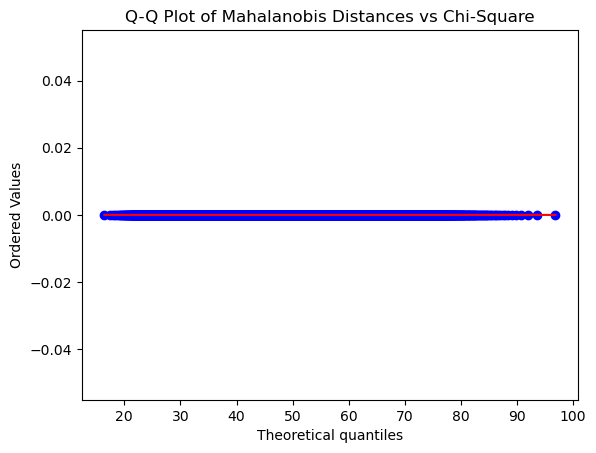

In [30]:
import scipy.stats as stats
def mahalanobis(X):
    cov = np.cov(X, rowvar=False)
    inv_cov = np.linalg.pinv(cov)
    mean = np.mean(X, axis=0)
    diff = X - mean
    return np.sqrt(np.sum(diff @ inv_cov * diff, axis=1))

distances = mahalanobis(X)

# Q-Q Plot against Chi-squared distribution
stats.probplot(distances**2, dist=stats.chi2, sparams=(X.shape[1],), plot=plt)
plt.title("Q-Q Plot of Mahalanobis Distances vs Chi-Square")
plt.show()

In [29]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination
outliers = iso.fit_predict(X) == -1
print(f"Isolation Forest detected {outliers.sum()} outliers.")

Isolation Forest detected 1983 outliers.


The isolation method captures much more outliers than the distance method, this difference shows how much the normality assumption effects the results.


##### Handling Outliers

Based on the previous section, we have observed that the data has both **univariate** and **multivariate** outliers, handling them depends on the following factors:
* **The Data distribution**: The normality assumption over the data will effect whether or not we will consider the multivariate outliers or not and how we handle them.
* **The model**: the handling of the outliers depends on whethere the model is effected by it or not.
* **Data correlation**: The choice of handling the outliers feature by feature or globally depends on how correlated the features are.

##### Model Based outlier handling:

**Decision trees and Random forest**:

These models are robust to outliers, so there is no need to handle anything.

**KNN**:

distance metrics are very sensitive to outliers, and one approach to handle it is feature scaling using robust scaler.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler

# Scale features (only the numerical ones)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)  # Transforms X to median=0, IQR=1

# Train KNN
model = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
model.fit(X_scaled, y)

**Naïve Bayes**:

- Feature independence assumption
- Probability estimates can be skewed by extreme values

In [ ]:
# Apply log transformation to continuous features
X_log = np.log1p(X)  # log(1+x) to handle zeros

**SVM**:

- Margin maximization sensitive to extreme points
- Kernel computations affected by outlier distances

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Use RBF kernel with proper scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use nu-SVC which is more robust
model = SVC(kernel='rbf', nu=0.1)  # nu controls outliers impact

# Or use Huber loss for SVR (regression)
from sklearn.svm import SVR
model = SVR(epsilon=0.1)  # epsilon in Huber loss


**ANN**:

- Gradient updates can be dominated by outliers
- Activation function saturation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Use robust activation functions
model = Sequential([
    Dense(64, activation='selu', input_shape=(X.shape[1],)),  # self-normalizing
    Dense(1, activation='linear')
])

# Use Huber loss for regression
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='huber_loss')  # Robust to outliers

# Or use batch normalization
model.add(BatchNormalization())


**Linear regression**:

- Normality of residuals
- Homoscedasticity
- Linear relationship

In [ ]:
from sklearn.linear_model import RANSACRegressor, HuberRegressor

# Option 1: RANSAC (random sample consensus)
model = RANSACRegressor(base_estimator=LinearRegression(),
                       max_trials=100,
                       residual_threshold=5.0)

# Option 2: Huber Regression
model = HuberRegressor(epsilon=1.35)  # Default epsilon

# Option 3: Quantile Regression
from sklearn.linear_model import QuantileRegressor
model = QuantileRegressor(quantile=0.5, alpha=1.0)

# With polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
